## 1. Setting up the environment

In [1]:
import numpy as np
import gym

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
# setting manual seed
torch.manual_seed(0)

#matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# imports for rendering outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

In [2]:
# lets set up the cartpole environment
env = gym.make('InvertedPendulum-v2')
env.seed(0)

# lets find about the action and state space
print("Action space: {} ... State space: {}".format(env.action_space,env.observation_space))

# lets print some info about action space range
action_high = env.action_space.high
action_low = env.action_space.low
print("action_high: {}\t action_low: {}".format(action_high,action_low))

Action space: Box(1,) ... State space: Box(4,)
action_high: [3.]	 action_low: [-3.]


In [3]:
# lets play a random episode

# reset env
state = env.reset()
step_count = 0
done = False

while (not done):
    # random action
    action = env.action_space.sample()
    # taking step in env
    next_state,reward,done,_ = env.step(action)
    
    # displaying progress
    print ("Step : {} ... state: {} ... action: {} ... reward: {} ... done: {}".format(step_count,
                                                                                       state,action,reward,done))
    
    # updating state and step count
    state = next_state
    step_count+=1

Step : 0 ... state: [-0.0089128   0.00930782  0.00265382 -0.00419965] ... action: [0.292881] ... reward: 1.0 ... done: False
Step : 1 ... state: [-0.00668364  0.00437209  0.10849747 -0.24007429] ... action: [1.2911361] ... reward: 1.0 ... done: False
Step : 2 ... state: [ 0.00708224 -0.02695686  0.57854292 -1.31657164] ... action: [0.61658025] ... reward: 1.0 ... done: False
Step : 3 ... state: [ 0.03457597 -0.08891396  0.79634197 -1.78602673] ... action: [0.2692991] ... reward: 1.0 ... done: False
Step : 4 ... state: [ 0.06826782 -0.16439436  0.88902792 -1.99886546] ... action: [-0.4580712] ... reward: 1.0 ... done: True


## 2. Defining the policy

In [4]:
# defining the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ("using",device)

using cpu


In [5]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.shape[0]

class Policy(nn.Module):
    
    def __init__(self,state_size,action_size,action_high,action_low,hidden_size=32):
        super(Policy, self).__init__()
        
        # action range
        self.action_high = torch.tensor(action_high)
        self.action_low = torch.tensor(action_low)
        
        # fc layers for the policy network
        self.fc1 = nn.Linear(state_size,hidden_size)
        self.fc2_action = nn.Linear(hidden_size,action_size)
        self.fc2_std = nn.Linear(hidden_size,action_size)
    
    def forward(self,state):
        net = F.relu(self.fc1(state))
        action_mean = F.sigmoid(self.fc2_action(net))
        # rescale action mean
        action_mean_ = (self.action_high-self.action_low)*action_mean + self.action_low
        action_std = F.sigmoid(self.fc2_std(net))
        return action_mean_,action_std
    
    def act(self,state):
        # converting state from numpy array to pytorch tensor on the "device"
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        action_mean,action_std = self.forward(state)
        prob_dist = Normal(action_mean[0],action_std[0])
        action = prob_dist.sample()
        log_prob = prob_dist.log_prob(action)
        return action.numpy(),log_prob

## 3. Defining the RL agent

In [15]:
from collections import deque
from itertools import accumulate

class Agent:
    
    def __init__(self,env,learning_rate=1e-3,std_start=1.0,std_decay=.999,std_end=0.1):
        self.env = env
        self.env.seed(0)
        nS = env.observation_space.shape[0]
        nA = env.action_space.shape[0]
        self.policy = Policy(state_size=nS,hidden_size=128,action_size=nA,
                             action_low=action_low,action_high=action_high).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate)
        self.std_start = std_start
        self.std_decay = std_decay
        self.std_end = std_end
    
    def train(self,max_opt_steps=1000,num_trajectories=10,horizon=1000,gamma=.99,PRINT_EVERY=100):
        # store eps scores
        scores = []
        scores_window = deque(maxlen=100)
        std = self.std_start
        
        for opt_step in range(1,max_opt_steps+1):
            future_reward_list = []#np.zeros([num_trajectories,horizon])
            log_prob_list = []
            
            for traj_count in range(num_trajectories):
                # reset state
                state = env.reset()
                total_reward = 0
                reward_list = []

                # play an episode
                for t in range(horizon): 
                    action,log_prob = self.policy.act(state)
                    next_state,reward,done,_ = self.env.step(action)
                    total_reward += reward

                    # update state
                    state = next_state
                    log_prob_list.append(log_prob)
                    reward_list.append(reward)

                    # decay std
                    std = max(std*self.std_decay,self.std_end)

                    # break if done
                    if done:
                        break
                
                # compute future rewards
                future_rewards = list(accumulate(reward_list[::-1], lambda x,y: x*gamma + y))[::-1]
                future_reward_list = future_reward_list + future_rewards
                #future_reward_list[traj_count,:] = future_rewards
            
            # compute advantage estimate to reduce variance
            future_reward_list = np.array(future_reward_list)
            b = future_reward_list.mean(axis=0)
            A = (future_reward_list - b)
            A = torch.tensor(list(A))
            log_probs = torch.cat(log_prob_list)

            # compute loss and applying gradient
            loss = torch.sum(-log_probs*A)/(num_trajectories*horizon)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # update scores and score_window
            scores.append(total_reward)
            scores_window.append(total_reward)
            
            #printing progress
            if opt_step % PRINT_EVERY == 0:
                print ("Episode: {} ... Avg reward: {:.2f}".format(opt_step,np.mean(scores_window))) 
            
            if np.mean(scores_window)>=195.0:
                print ("Environment solved in {} optimization steps! ... Avg reward : {:.2f}".format(opt_step-100,
                                                                                          np.mean(scores_window)))
                break
                
        return scores

## 4. Training the agent!

In [16]:
# lets define and train our agent
agent = Agent(env,learning_rate=1e-4,std_start=2.0,std_end=.2,std_decay=.99999)
scores = agent.train(max_opt_steps=3000,horizon=200,gamma=1.0,PRINT_EVERY=100)

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Episode: 100 ... Avg reward: 23.08
Episode: 200 ... Avg reward: 28.76
Episode: 300 ... Avg reward: 33.18
Episode: 400 ... Avg reward: 39.67
Episode: 500 ... Avg reward: 53.44
Episode: 600 ... Avg reward: 56.28
Episode: 700 ... Avg reward: 72.31
Episode: 800 ... Avg reward: 100.63
Episode: 900 ... Avg reward: 121.35
Episode: 1000 ... Avg reward: 152.99
Episode: 1100 ... Avg reward: 171.81
Episode: 1200 ... Avg reward: 180.98
Episode: 1300 ... Avg reward: 185.76
Episode: 1400 ... Avg reward: 193.10
Environment solved in 1340 optimization steps! ... Avg reward : 195.42


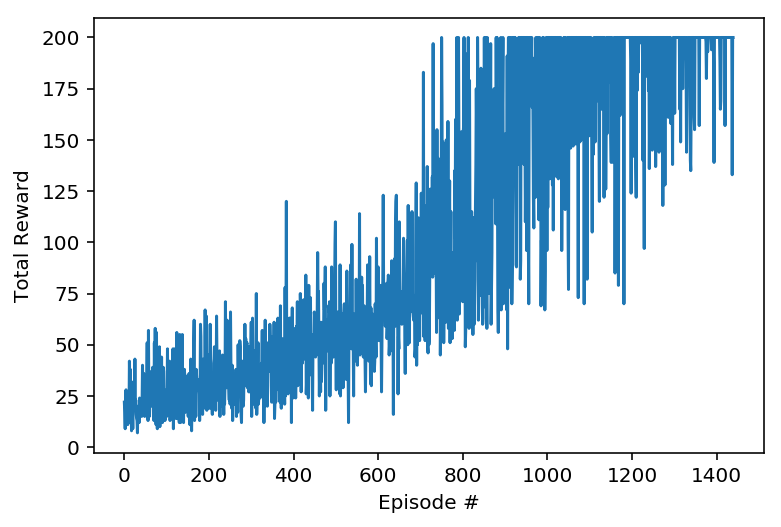

In [17]:
# plot reward curve over episodes
plt.figure()
plt.plot(scores)
plt.xlabel('Episode #')
plt.ylabel('Total Reward')
plt.show()

In [18]:
# save the policy
torch.save(agent.policy, 'REINFORCE.policy')

# load policy
# policy =  torch.load('REINFORCE.policy')
# agent = Agent(env)
# agent.policy = policy

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Policy. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## 5. Watch the smart agent!

In [19]:
# function to animate a list of frames
def animate_frames(frames):
    plt.figure(dpi = 72)
    plt.axis('off')

    # color option for plotting
    # use Greys for greyscale
    cmap = None if len(frames[0].shape)==3 else 'Greys'
    patch = plt.imshow(frames[0], cmap=cmap)  

    fanim = animation.FuncAnimation(plt.gcf(), \
        lambda x: patch.set_data(frames[x]), frames = len(frames), interval=30)
    
    display(display_animation(fanim, default_mode='once'))

/Users/jsingh/anaconda3/envs/cv3/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Creating offscreen glfw
Total reward: 335.0



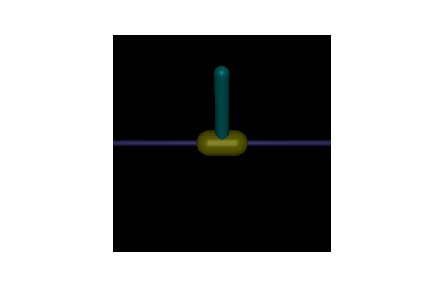
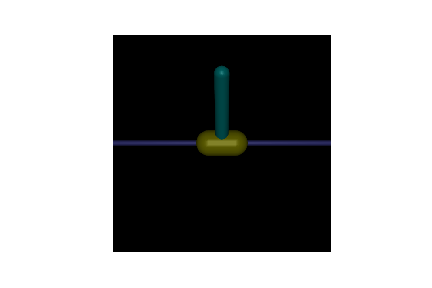
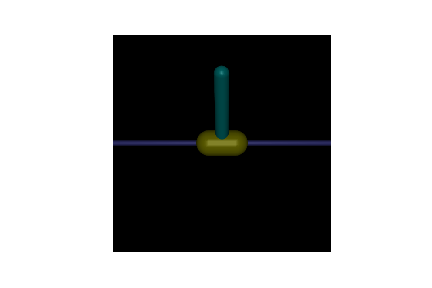
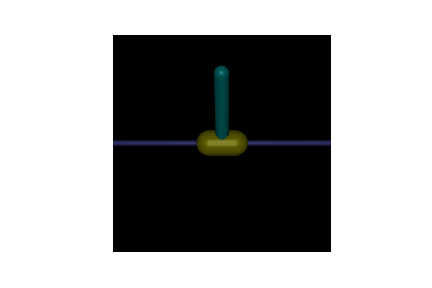
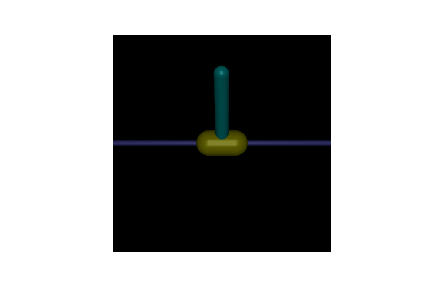
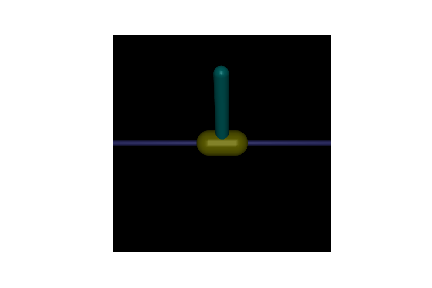
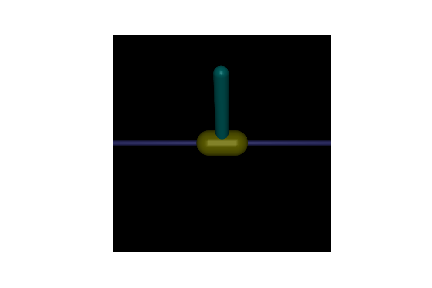
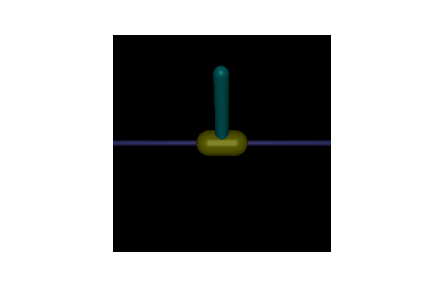
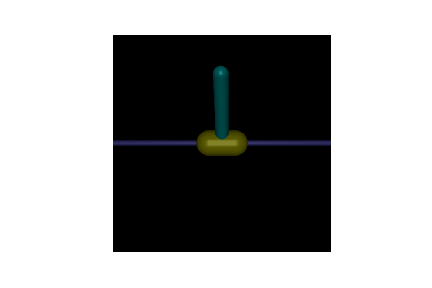
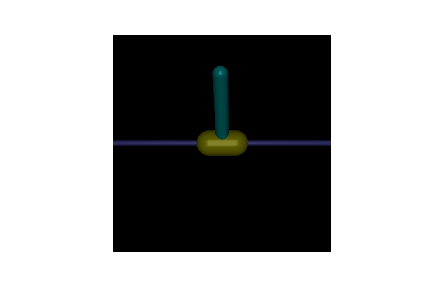
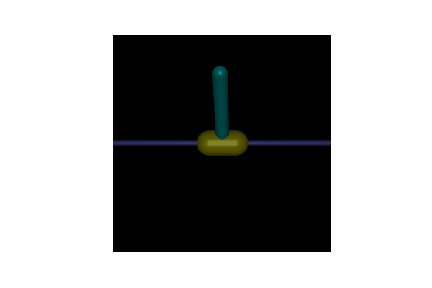
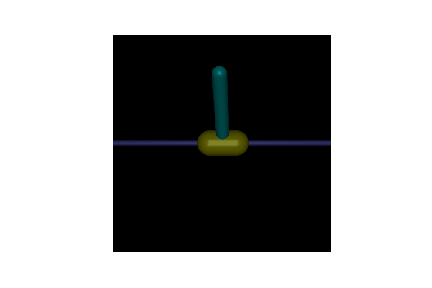
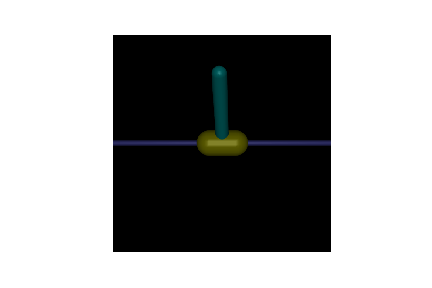
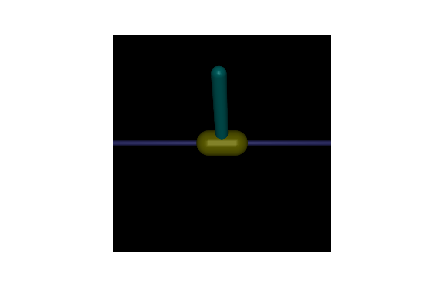
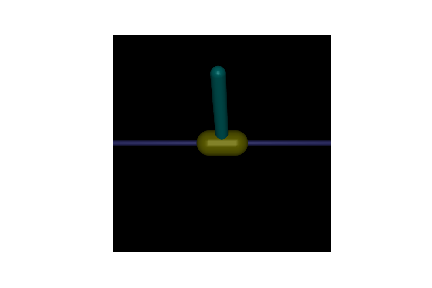
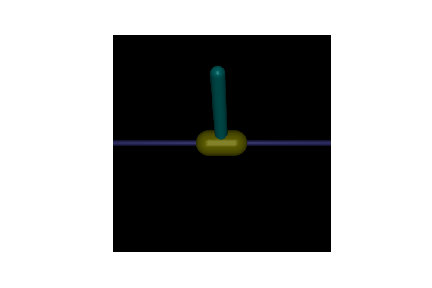
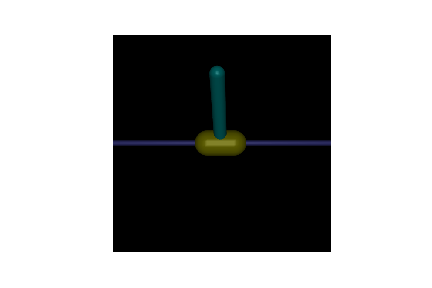
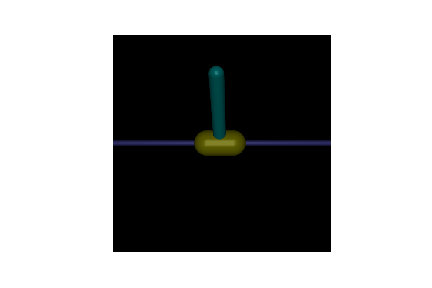
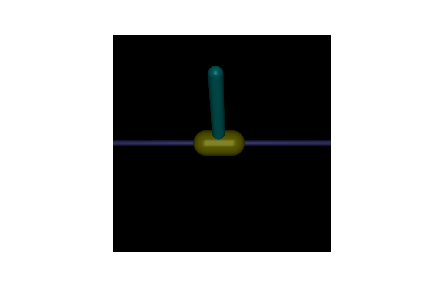
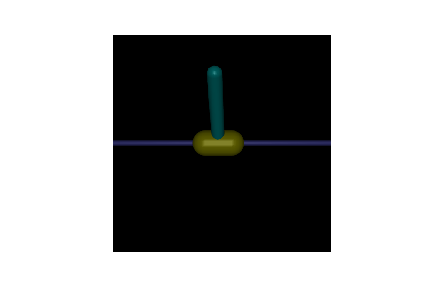
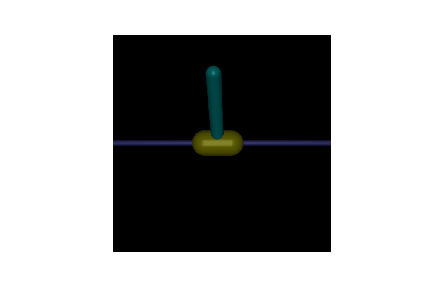
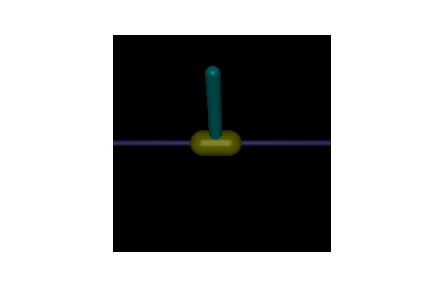
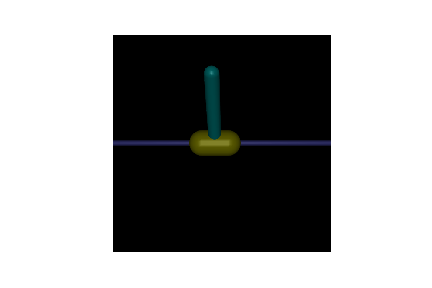
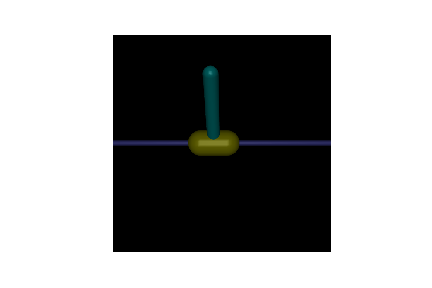
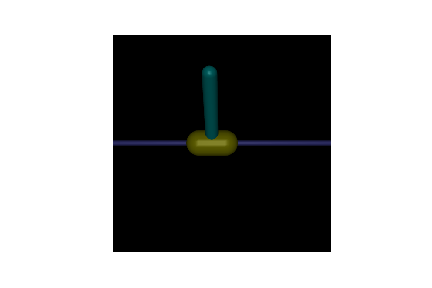
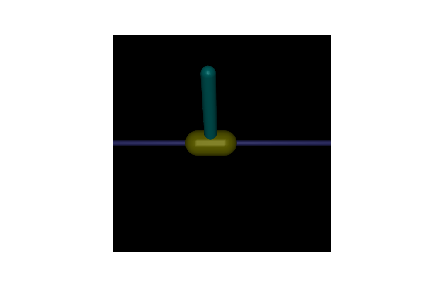
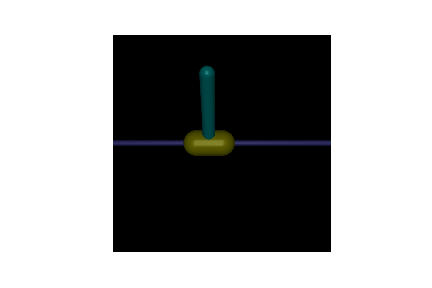
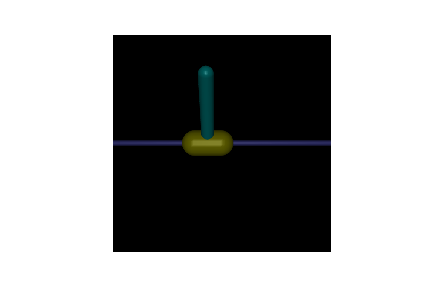
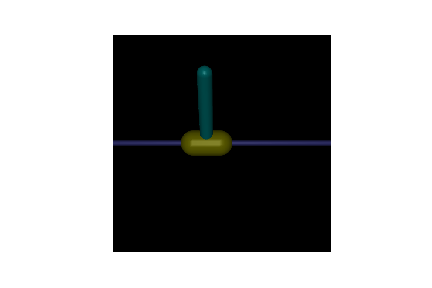
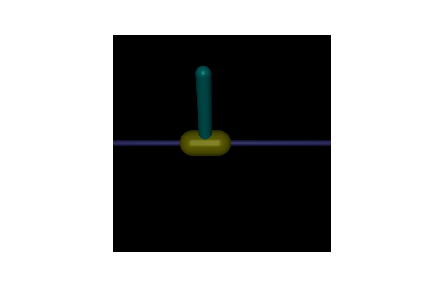
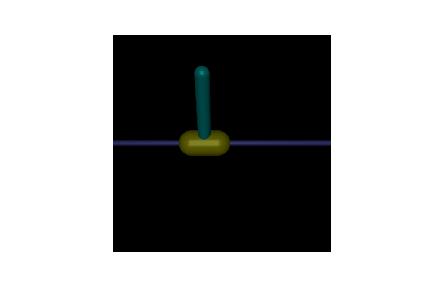
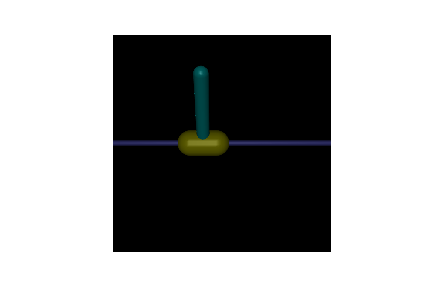
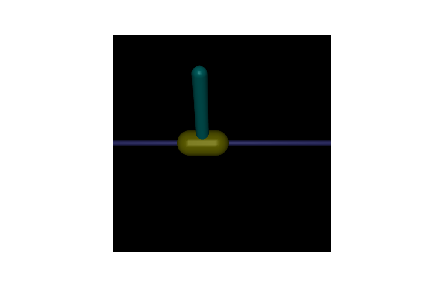
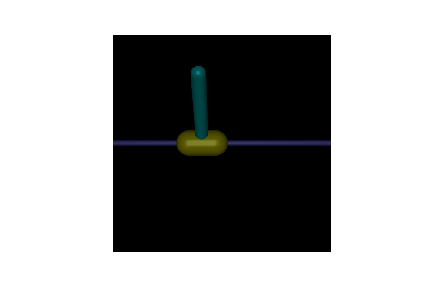
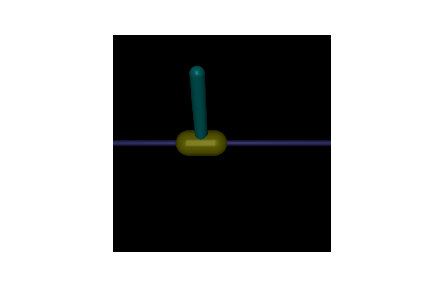
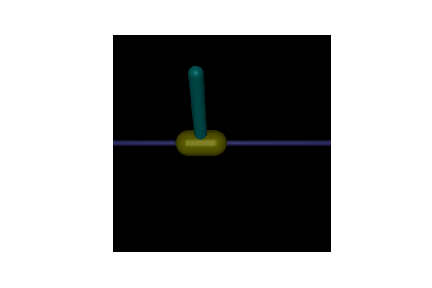
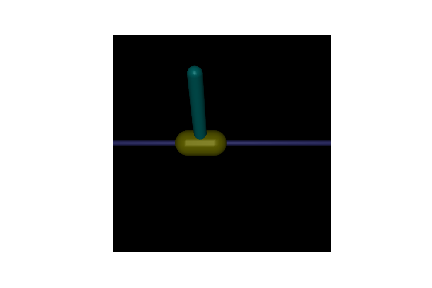
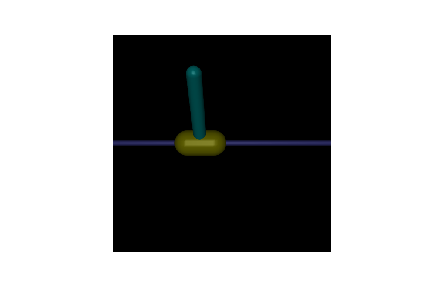
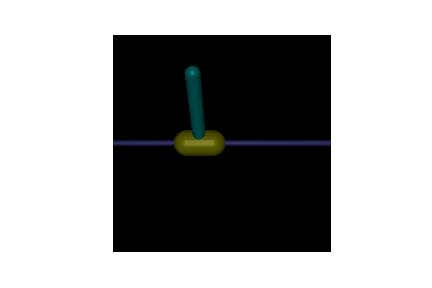
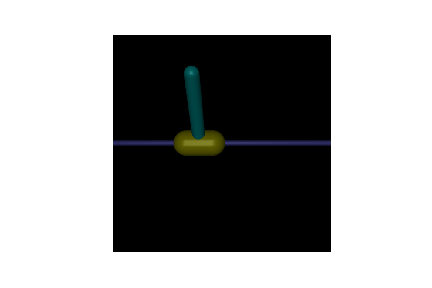
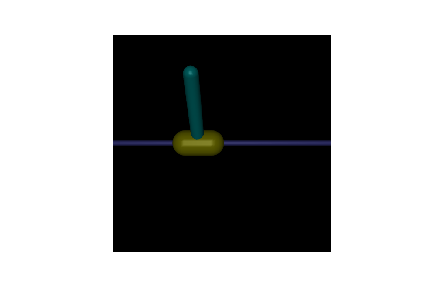
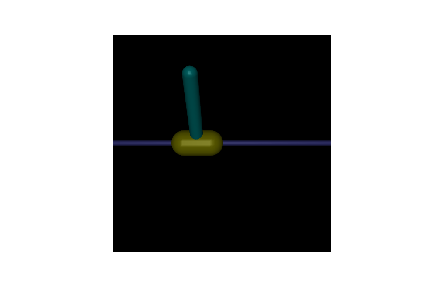
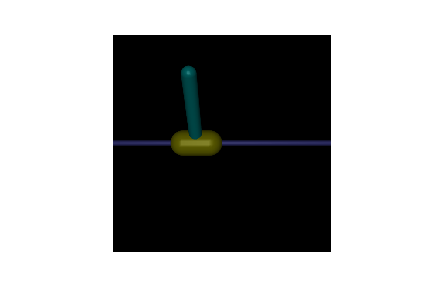
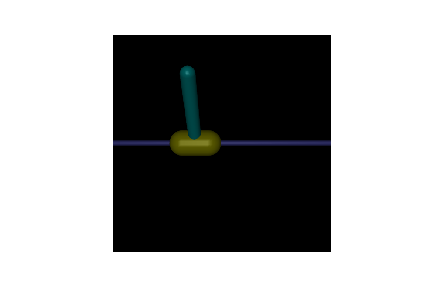
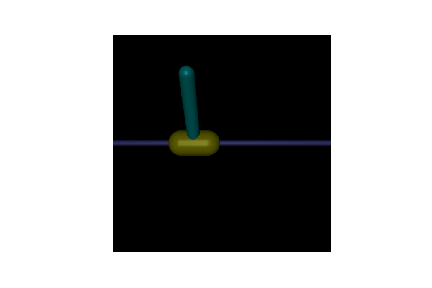
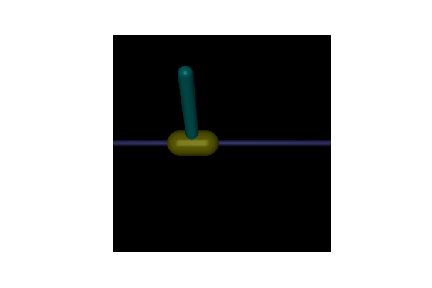
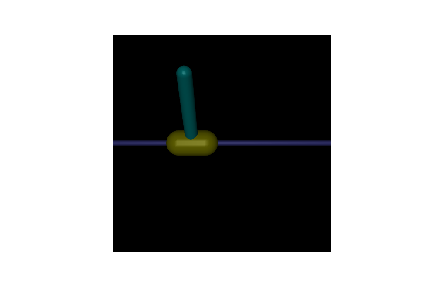
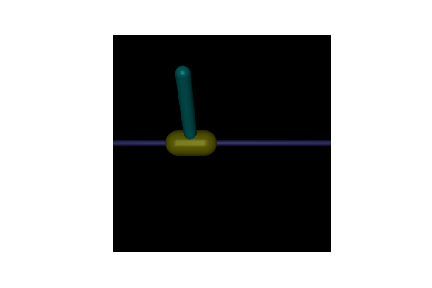
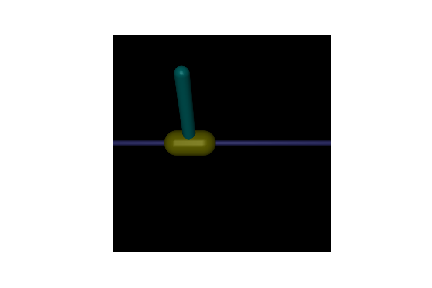
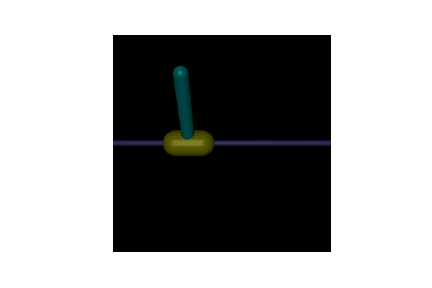
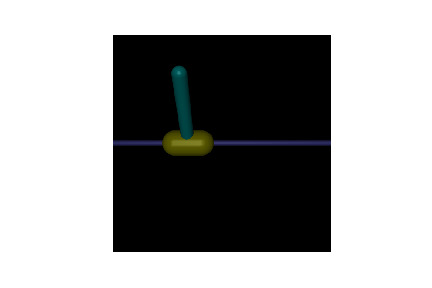
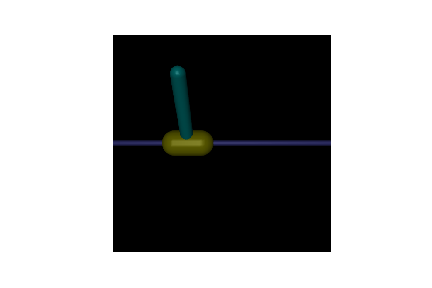
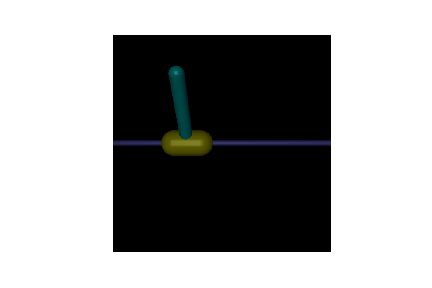
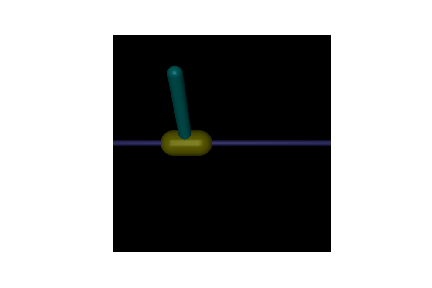
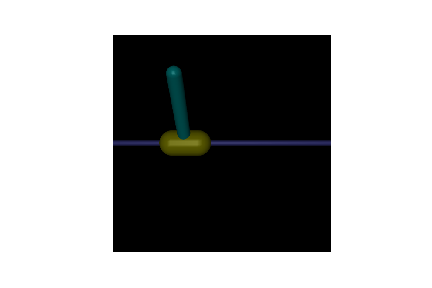
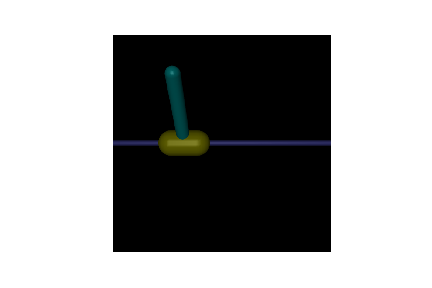
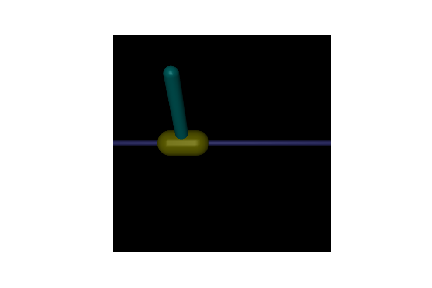
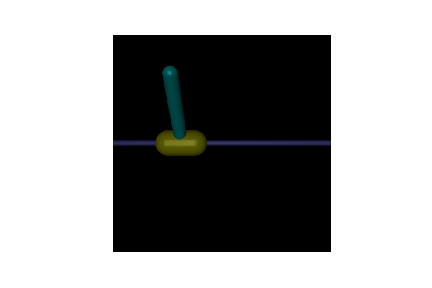
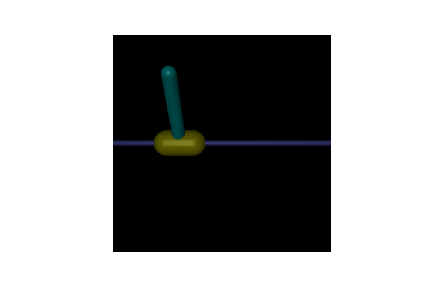
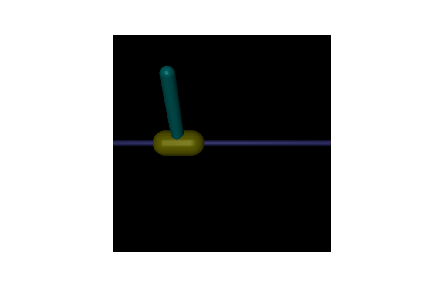
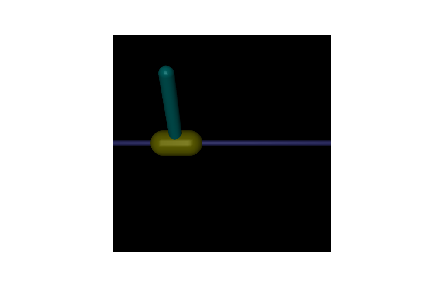
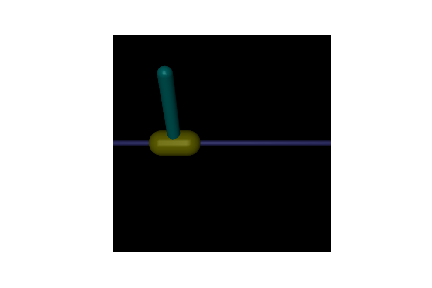
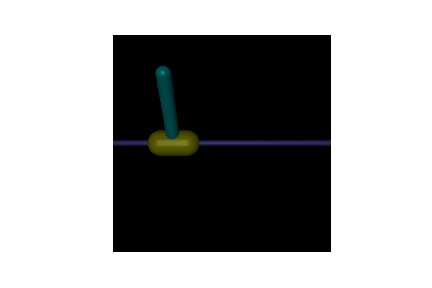
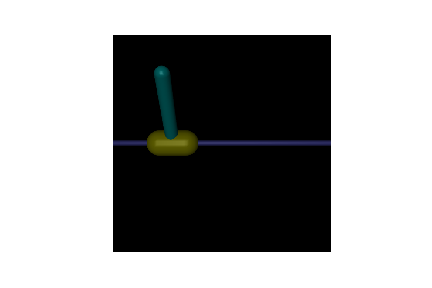
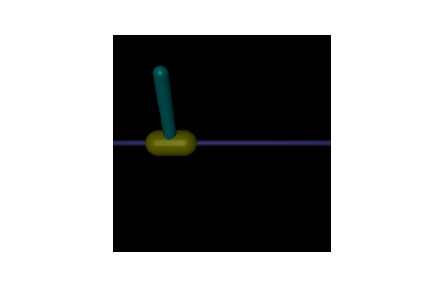
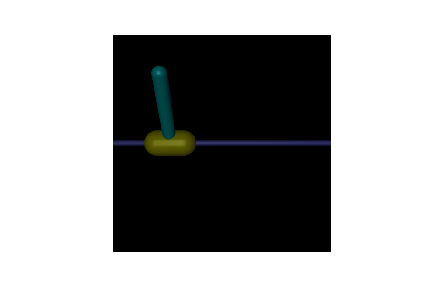
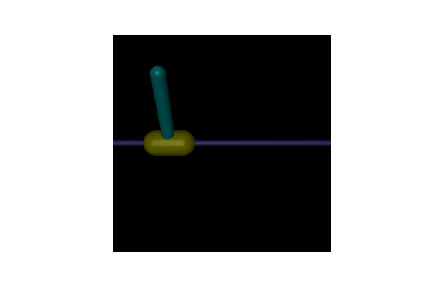
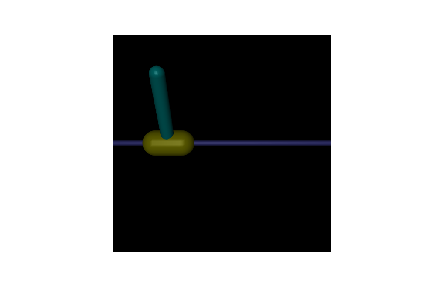
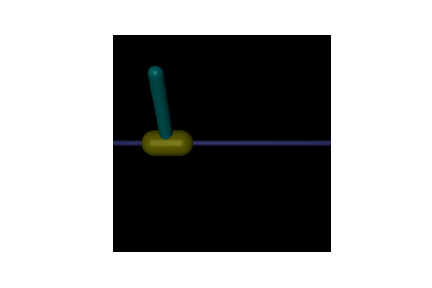
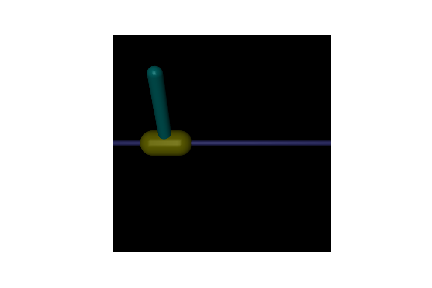
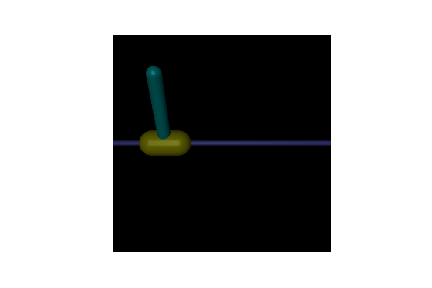
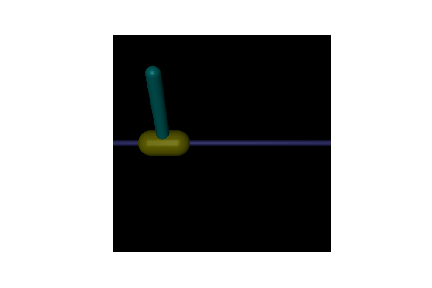
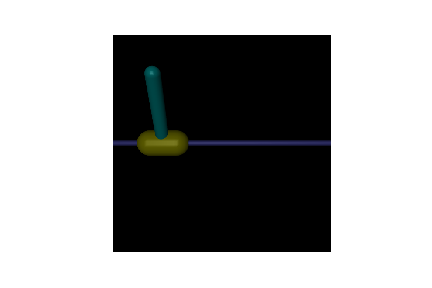
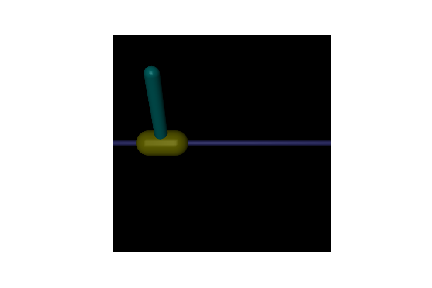
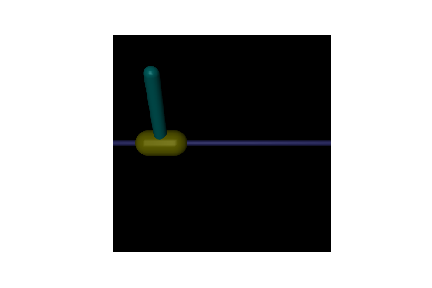
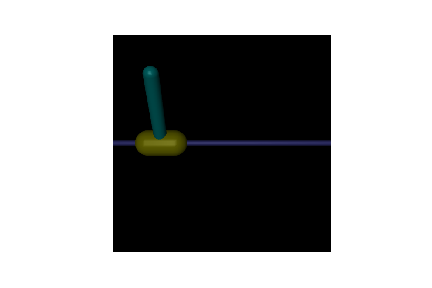
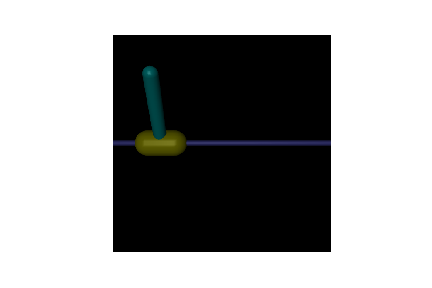
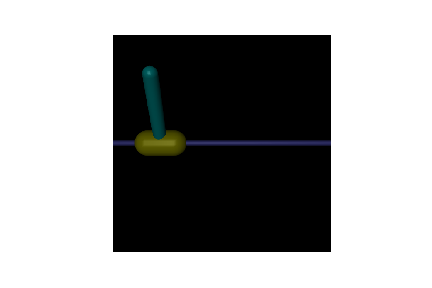
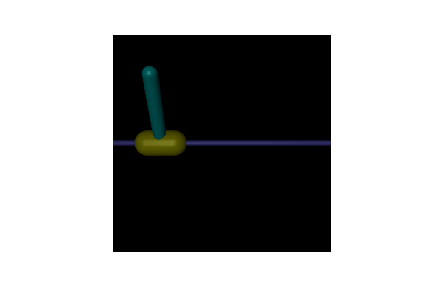
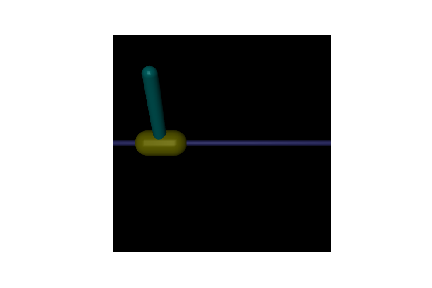
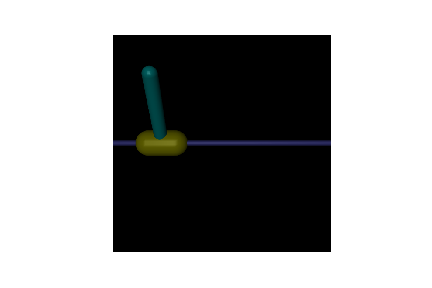
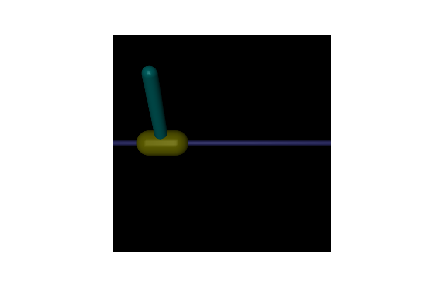
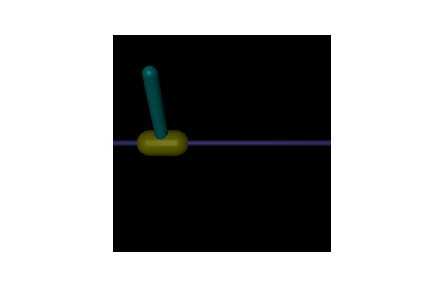
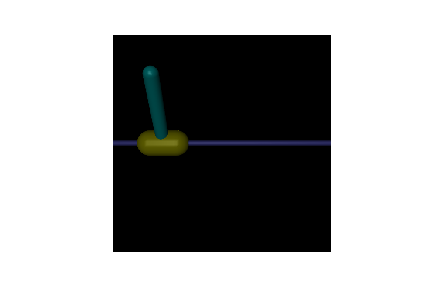
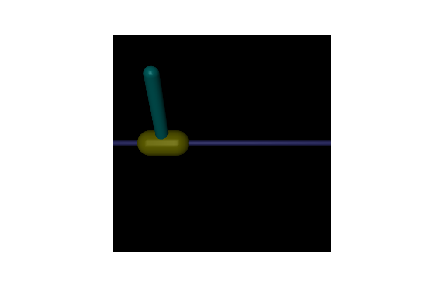
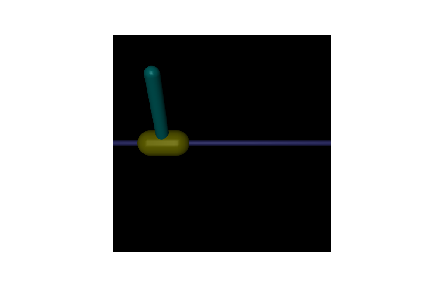
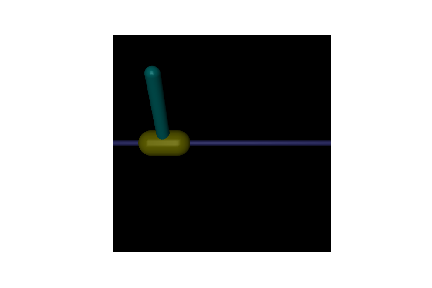
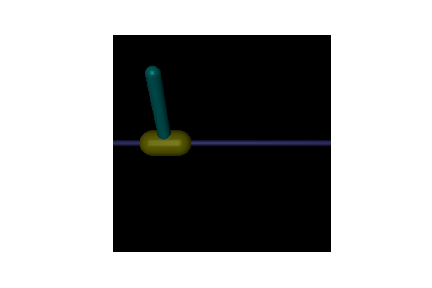
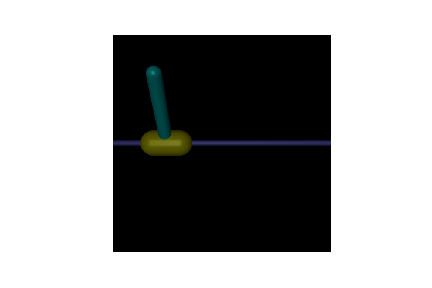
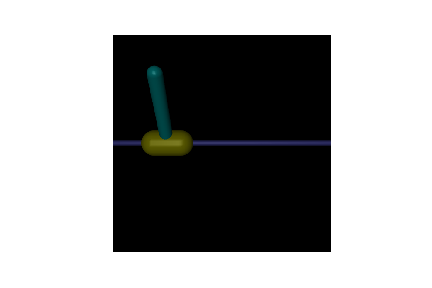
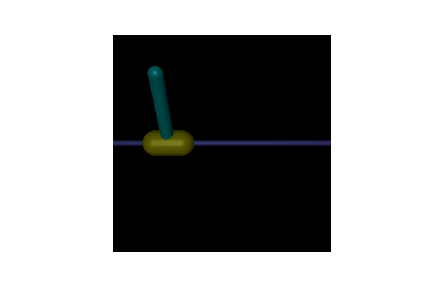
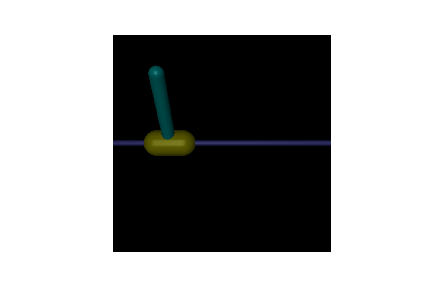
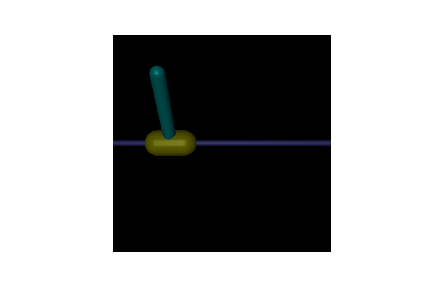
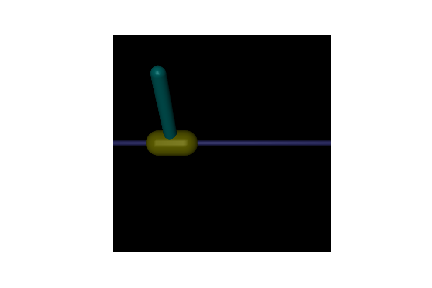
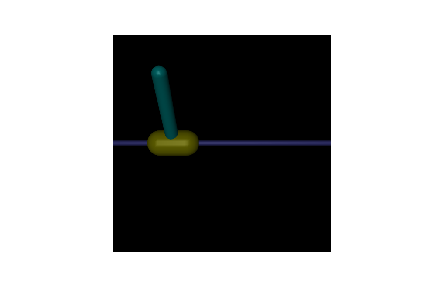
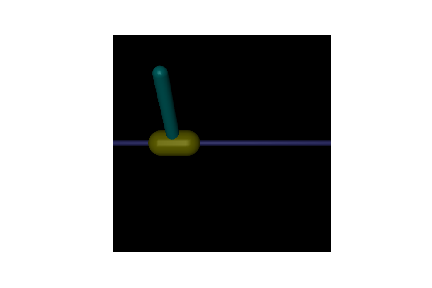
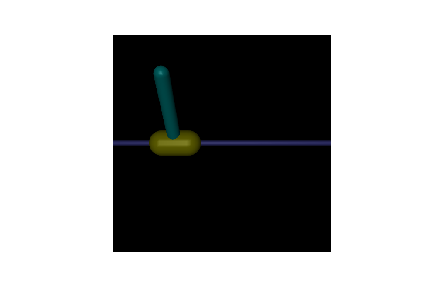
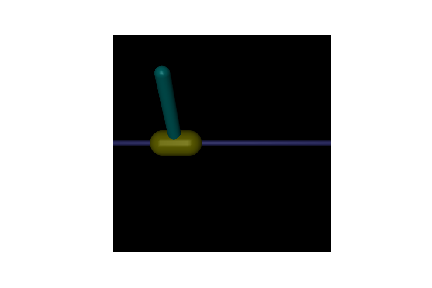
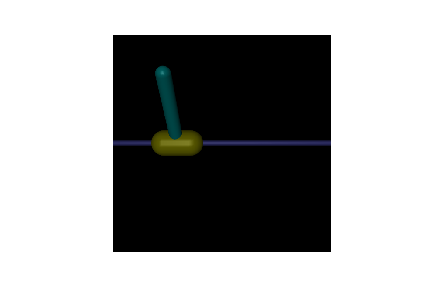
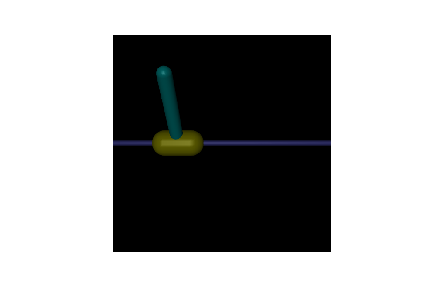
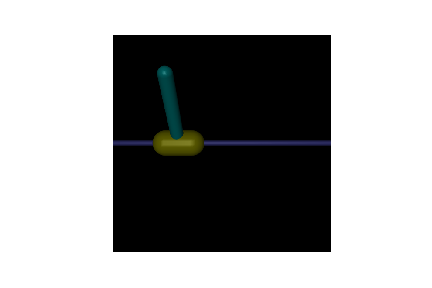
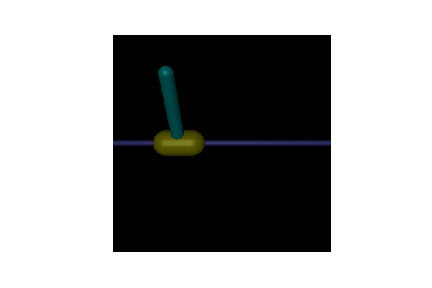
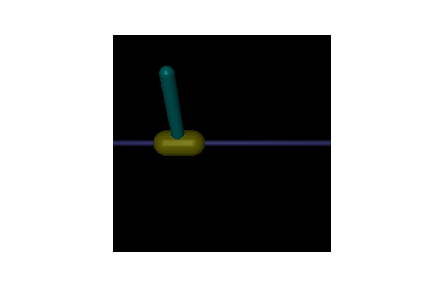
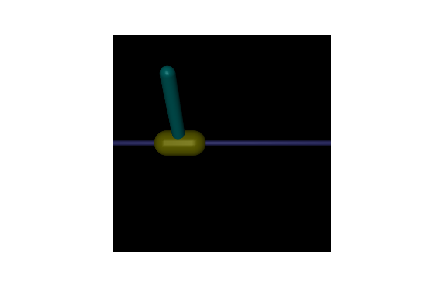
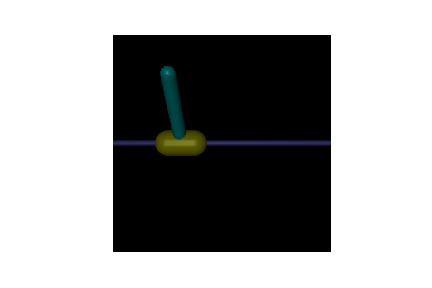
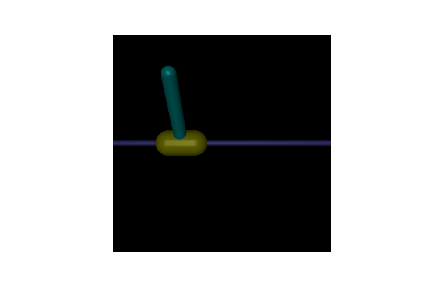
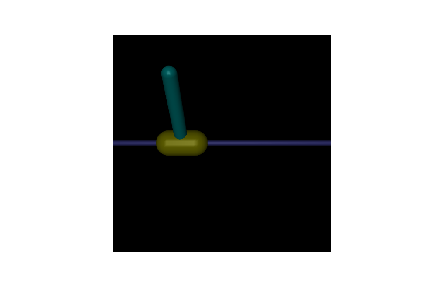
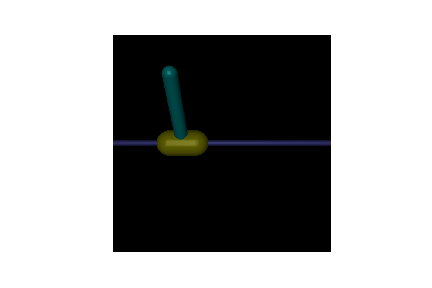
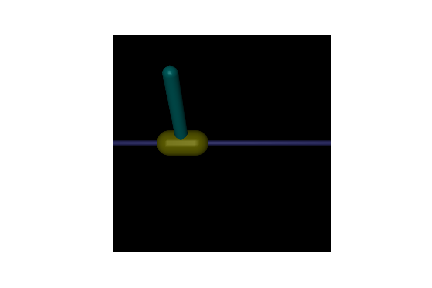
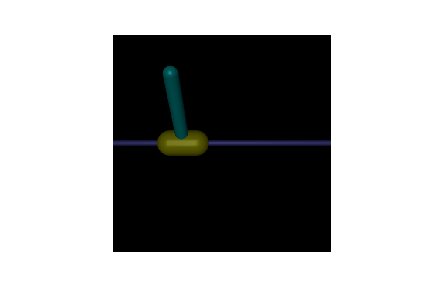
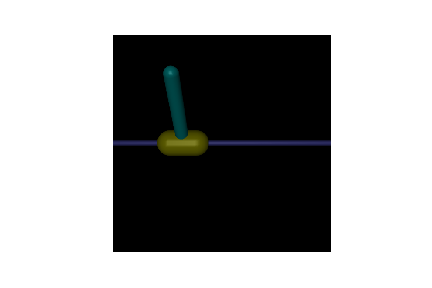
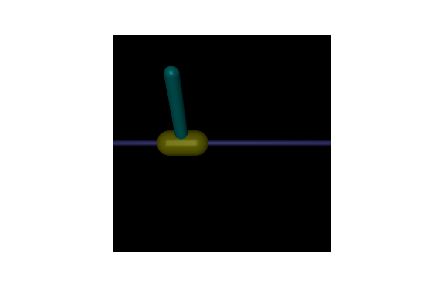
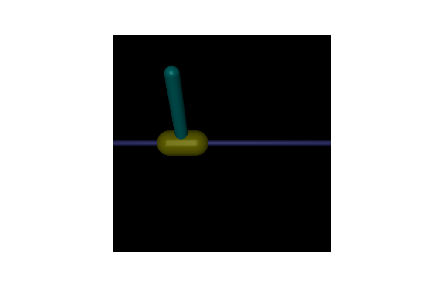
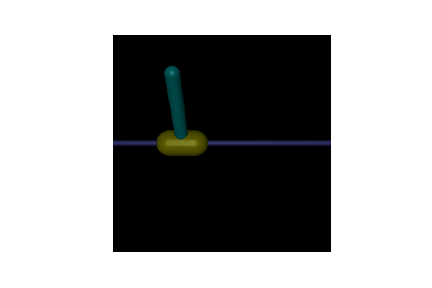
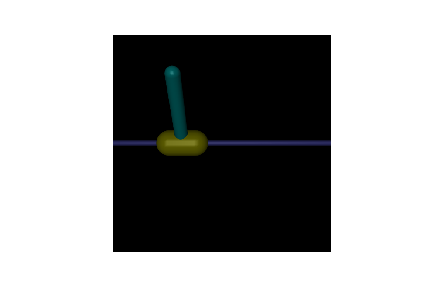
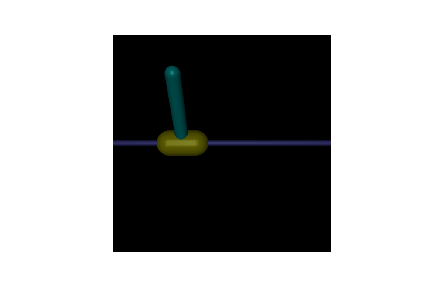
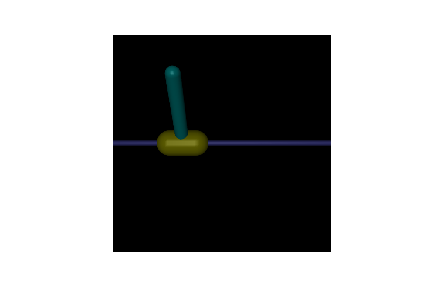
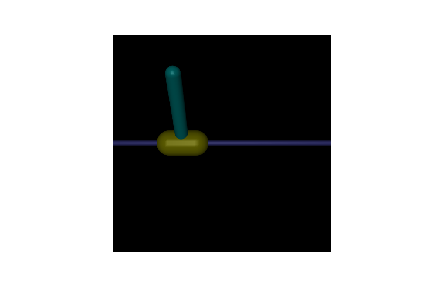
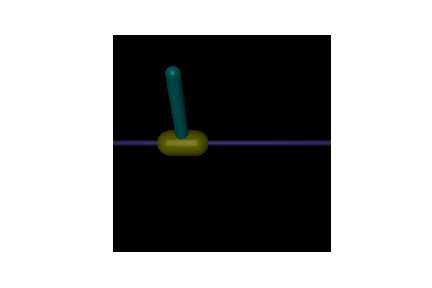
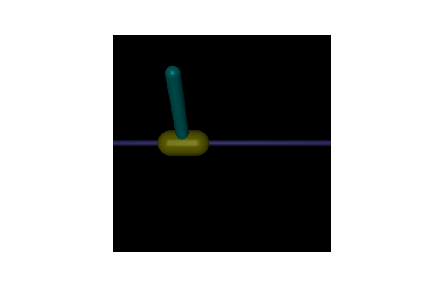
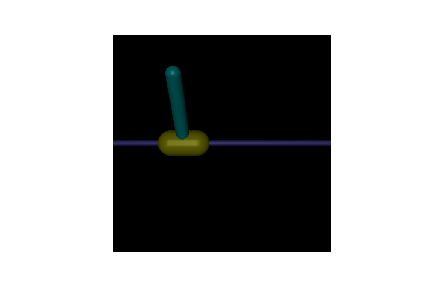
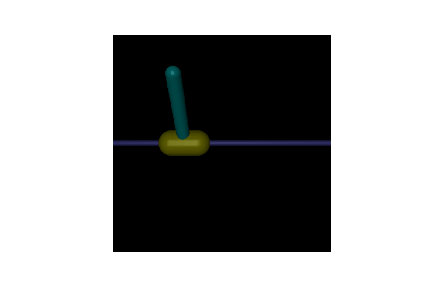
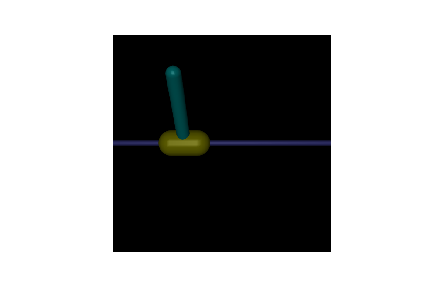
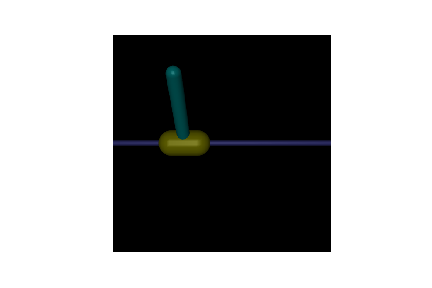
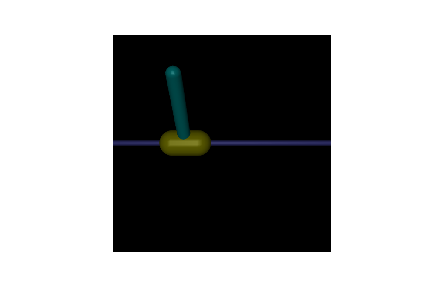
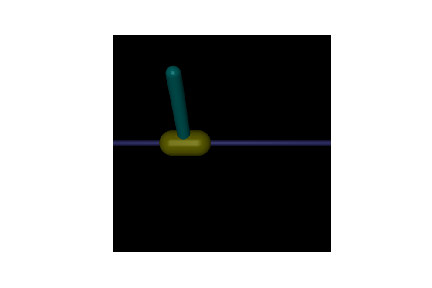
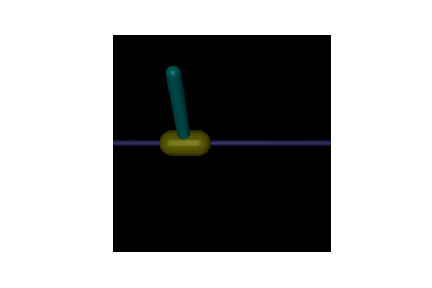
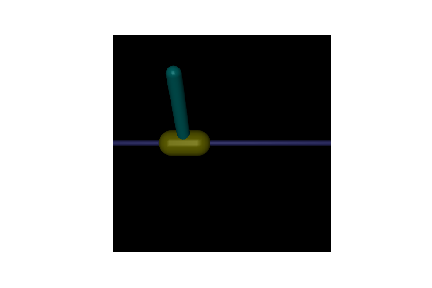
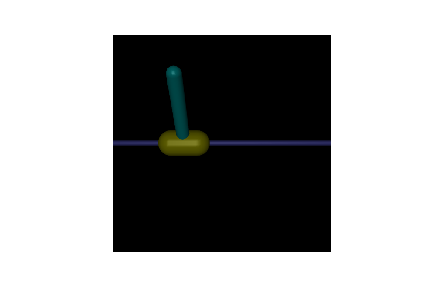
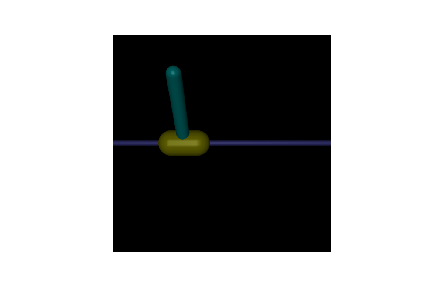
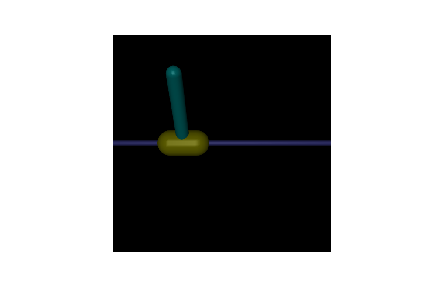
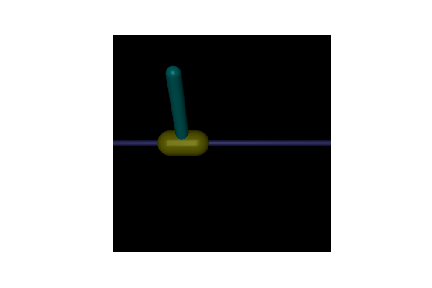
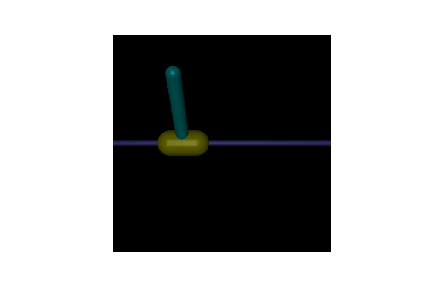
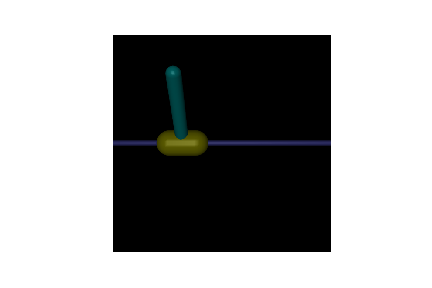
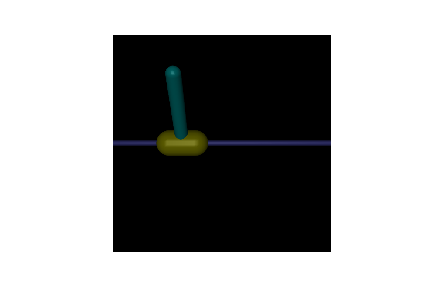
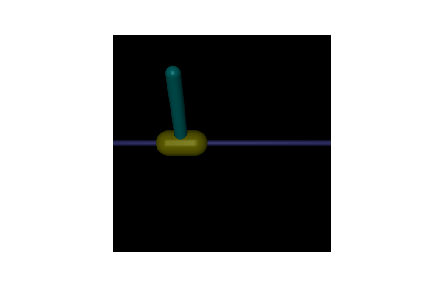
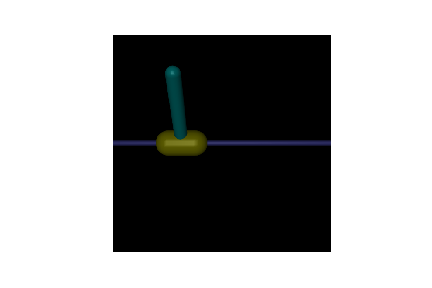
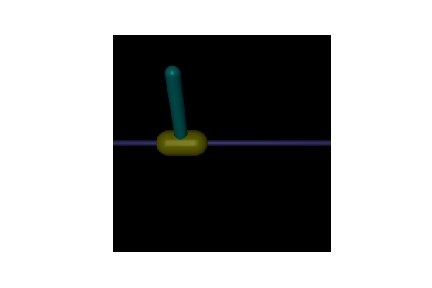
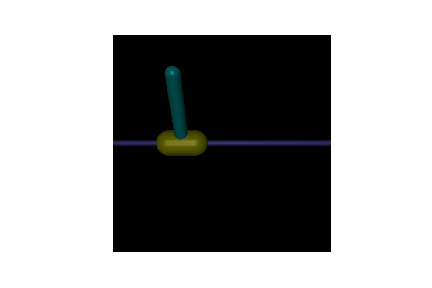
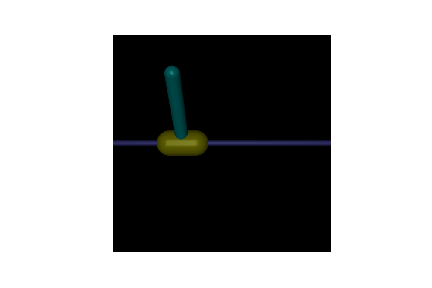
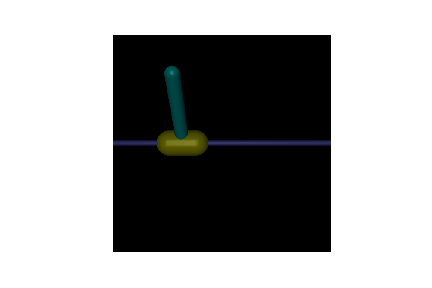
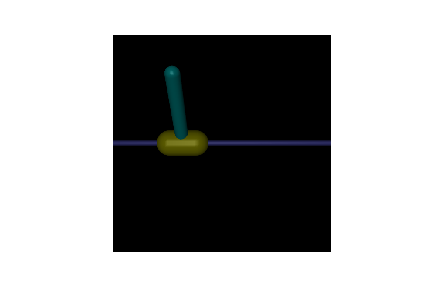
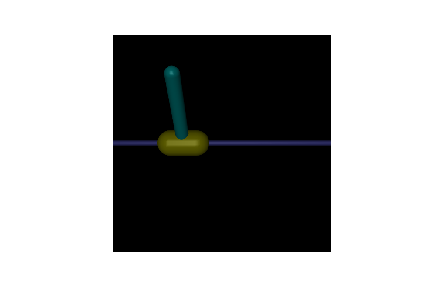
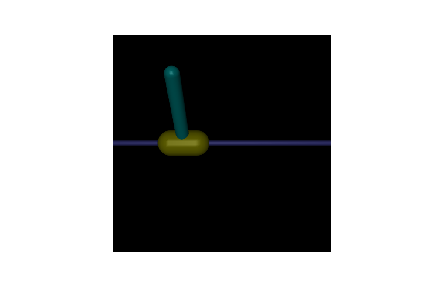
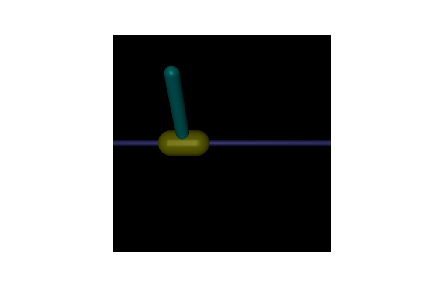
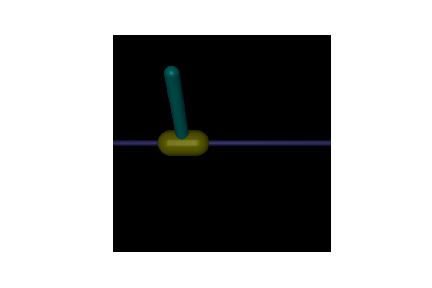
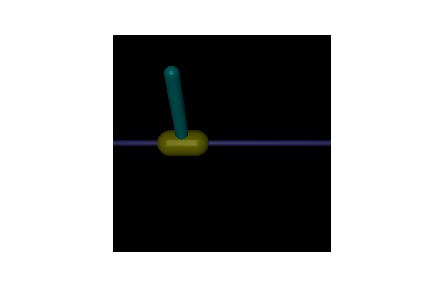
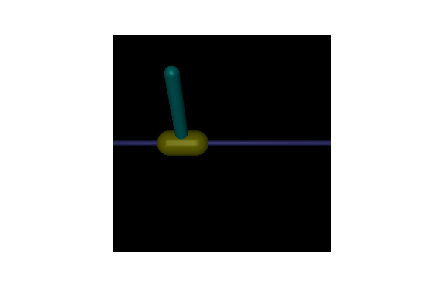
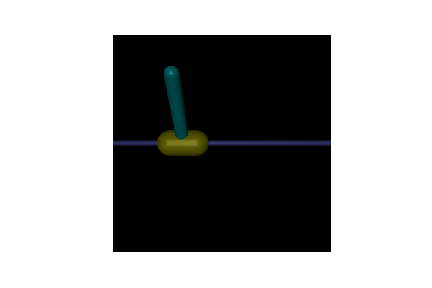
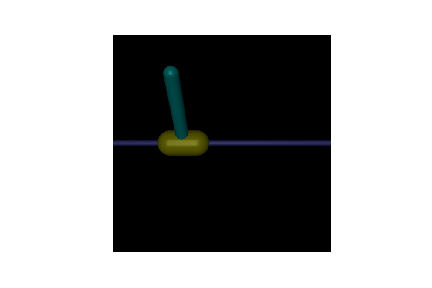
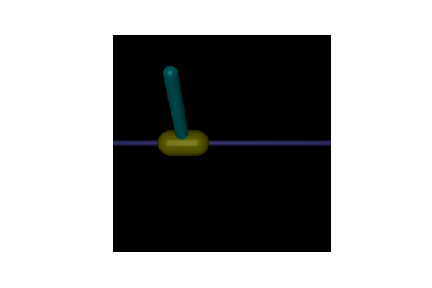
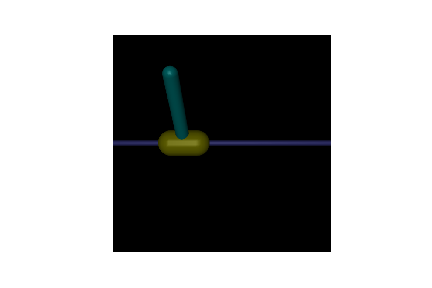
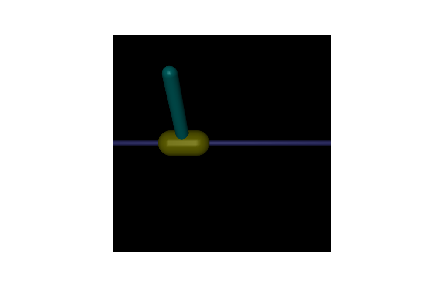
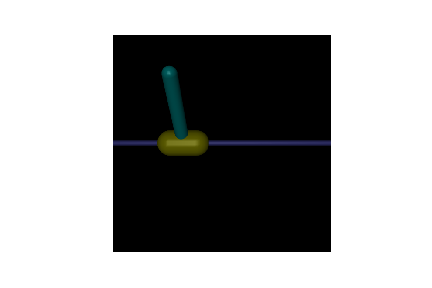
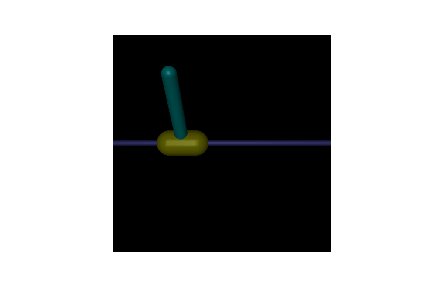
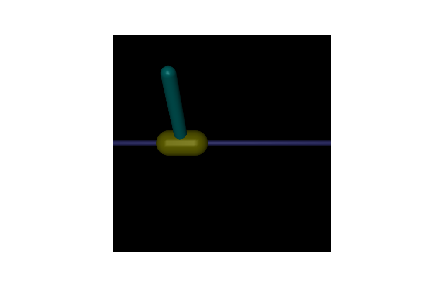
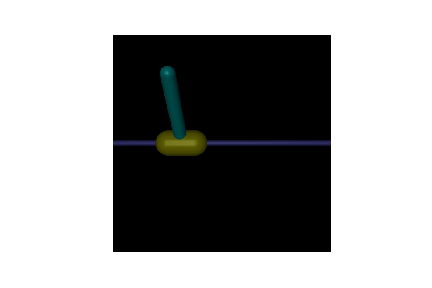
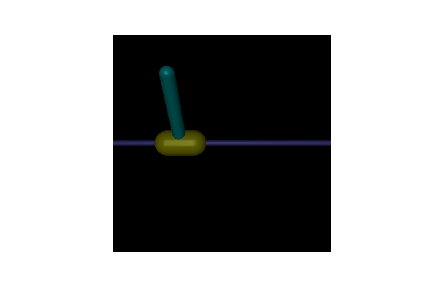
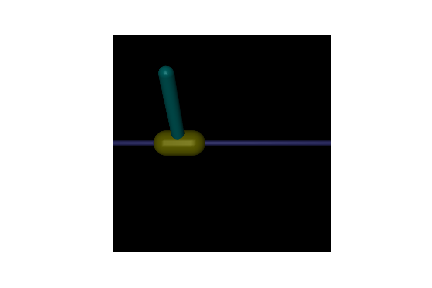
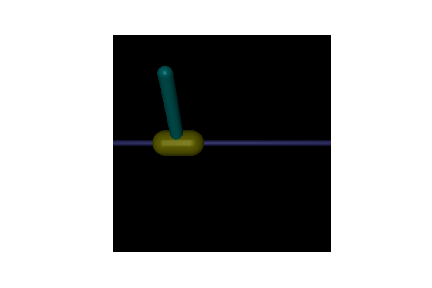
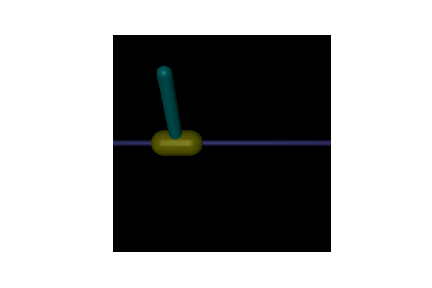
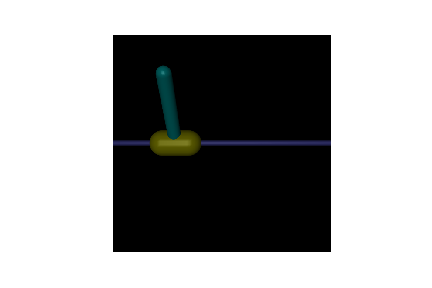
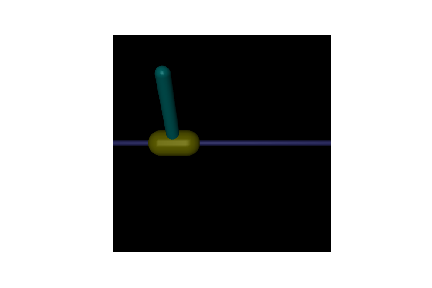
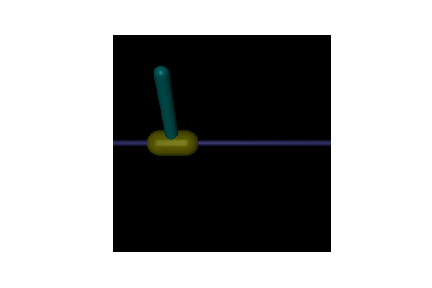
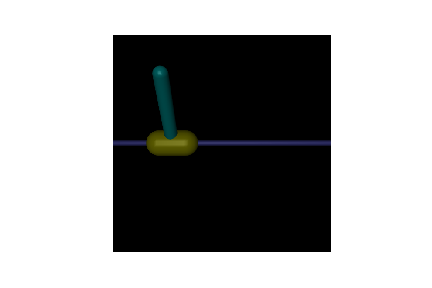
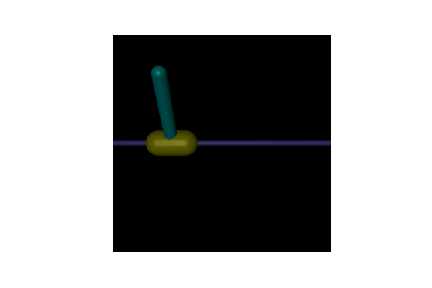
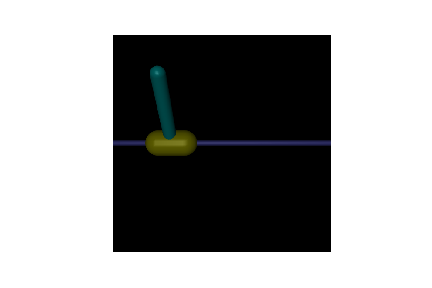
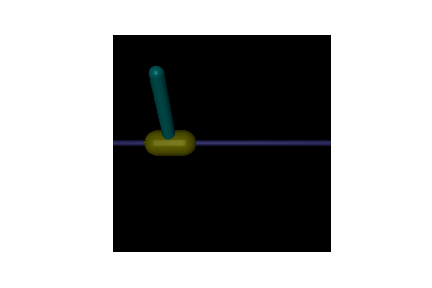
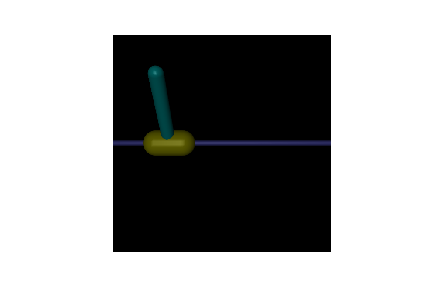
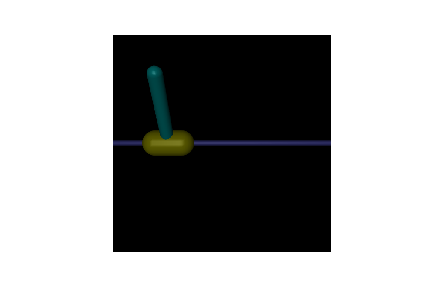
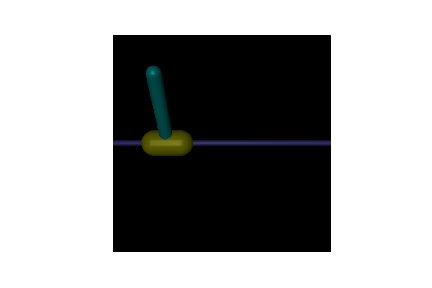
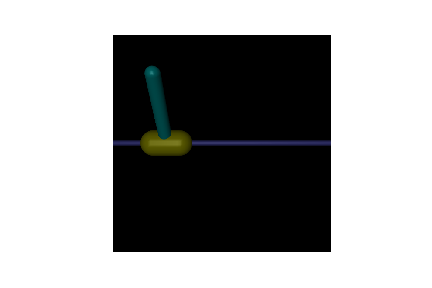
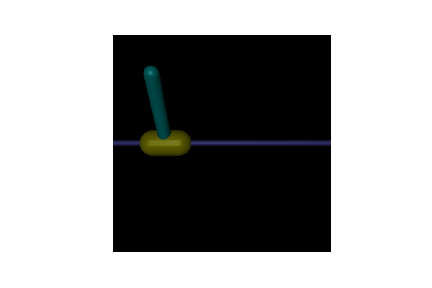
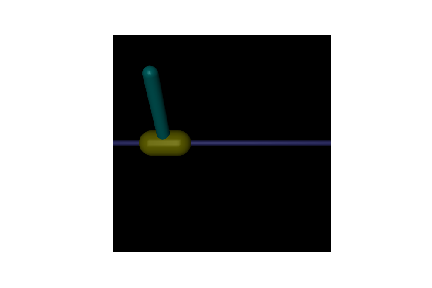
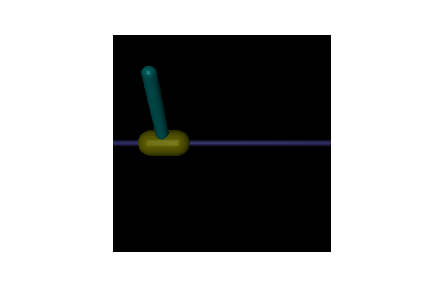
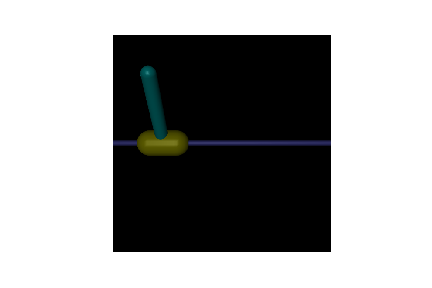
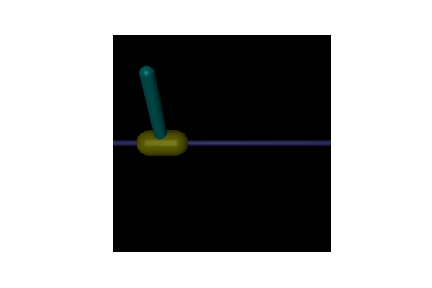
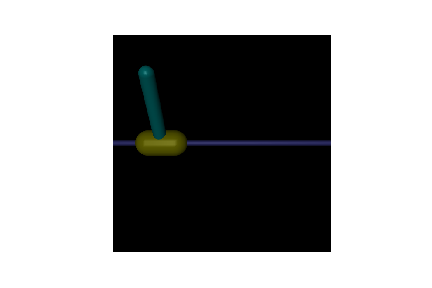
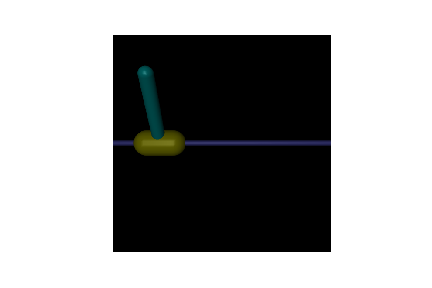
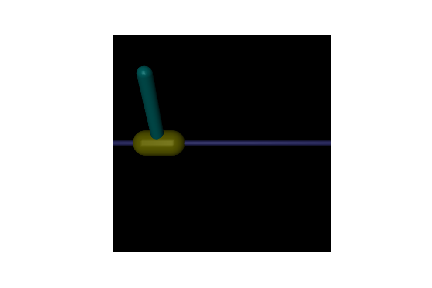
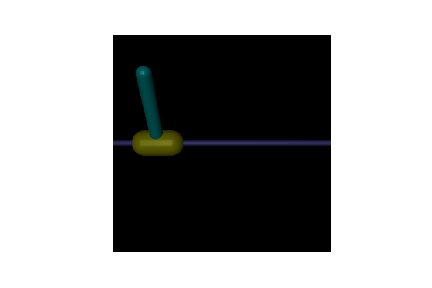
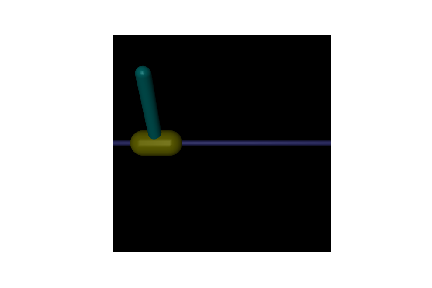
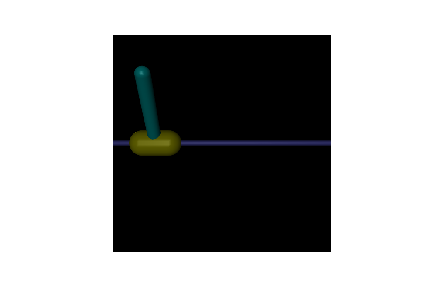
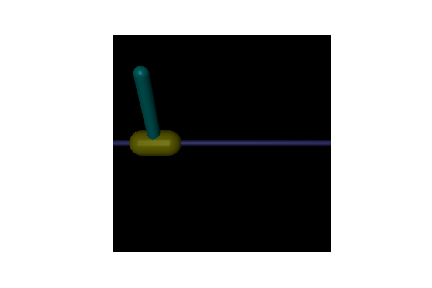
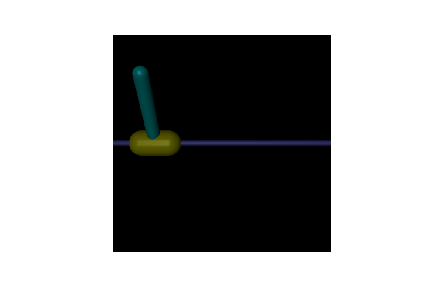
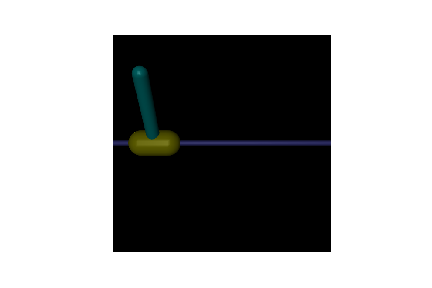
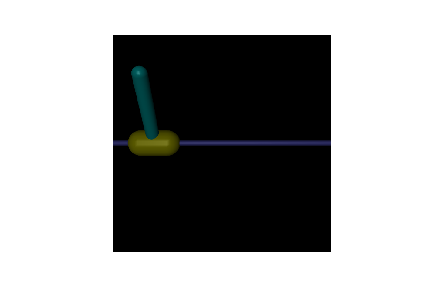
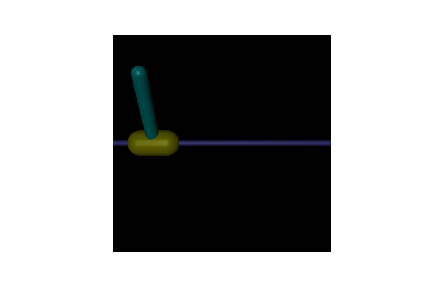
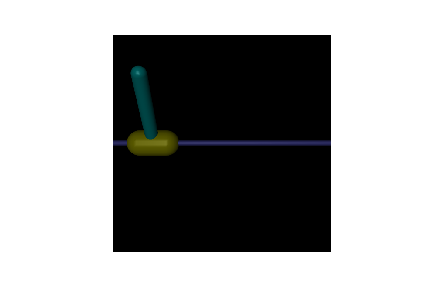
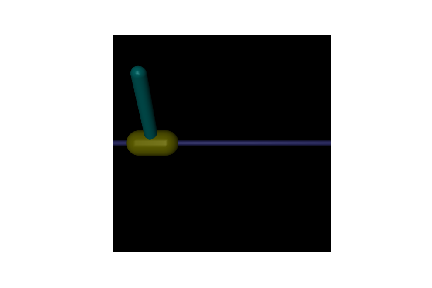
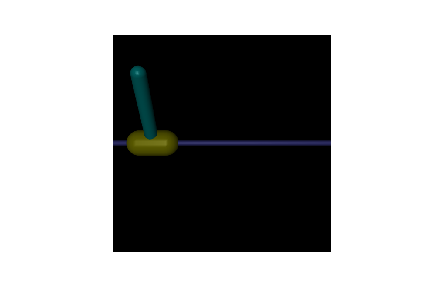
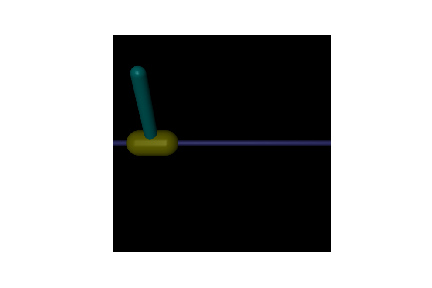
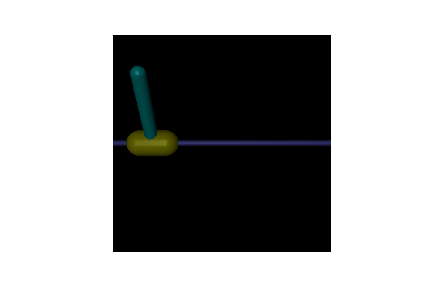
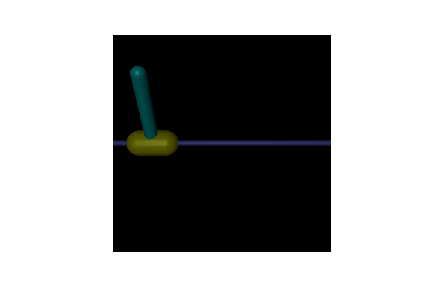
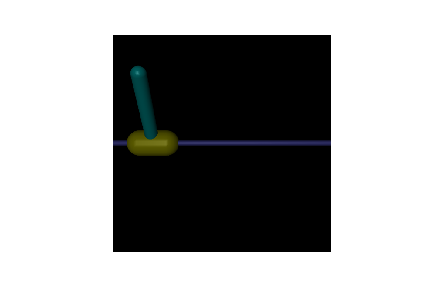
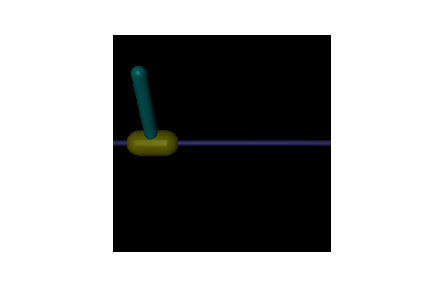
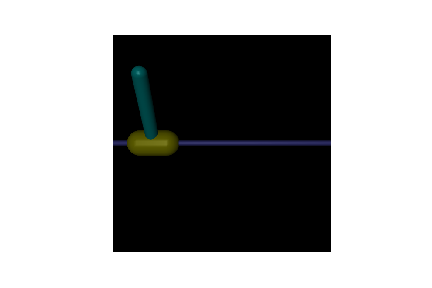
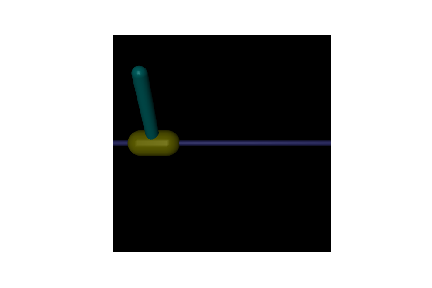
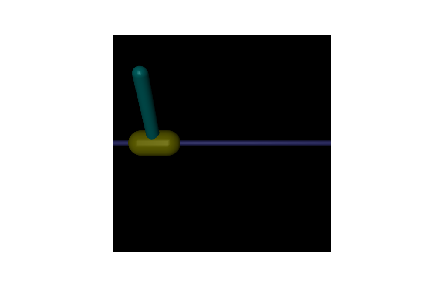
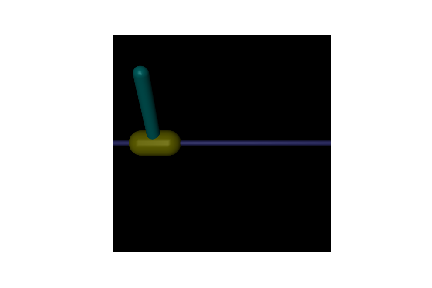
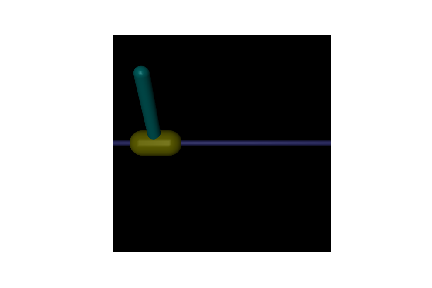
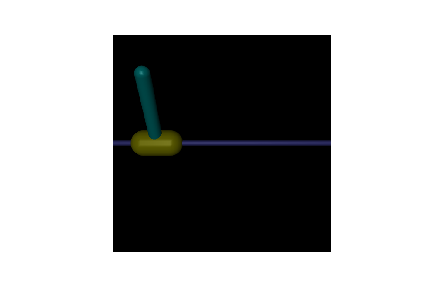
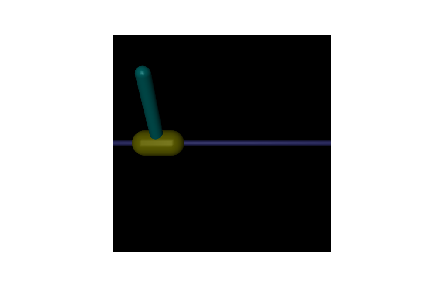
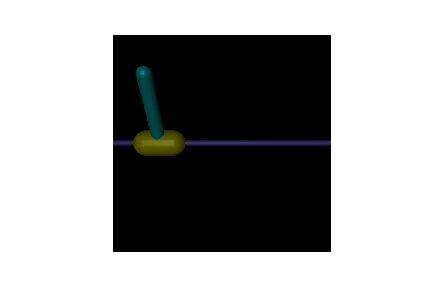
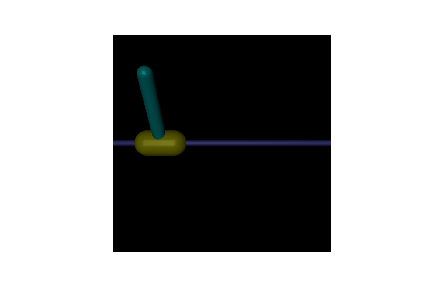
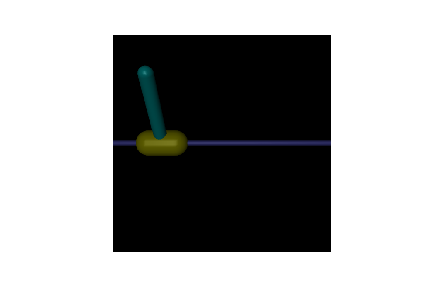
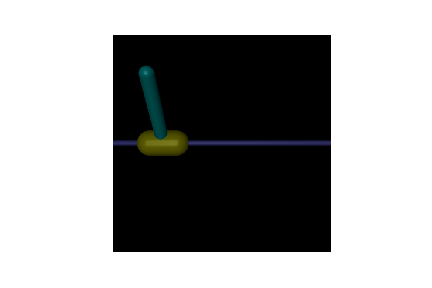
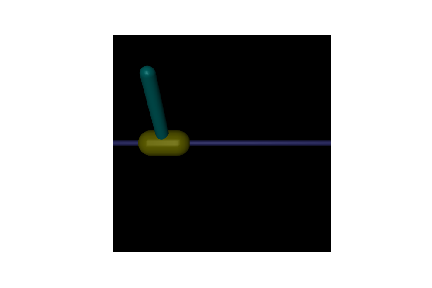
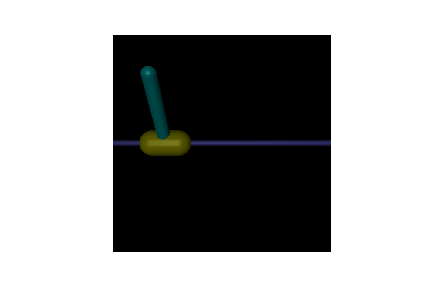
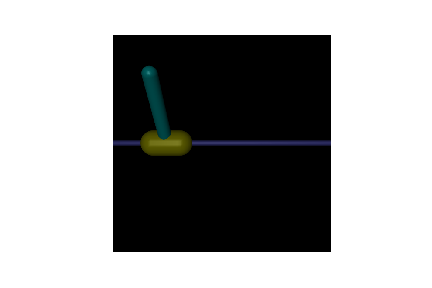
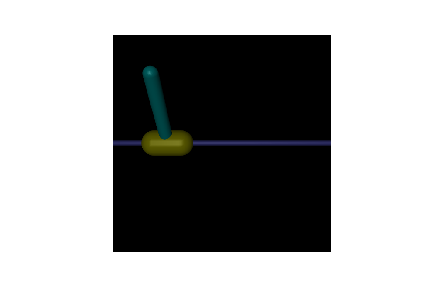
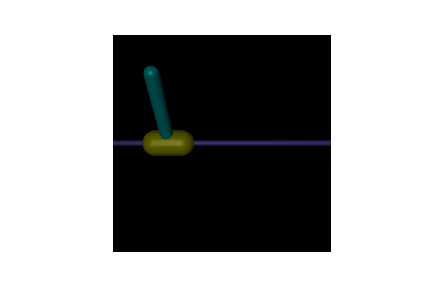
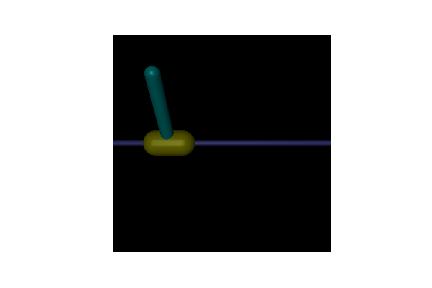
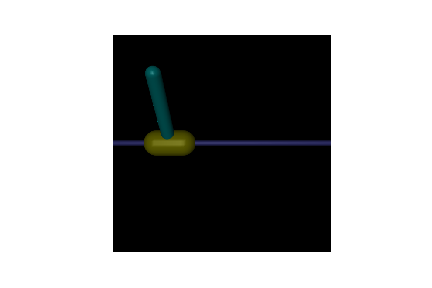
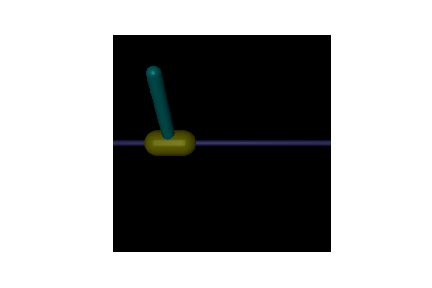
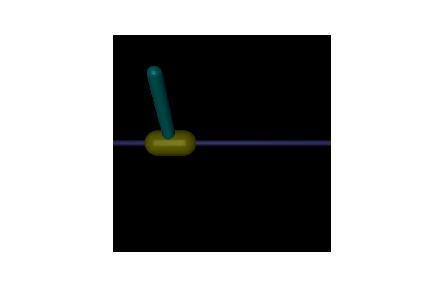
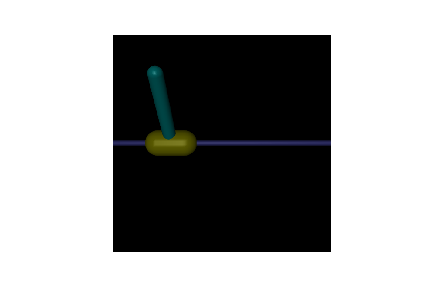
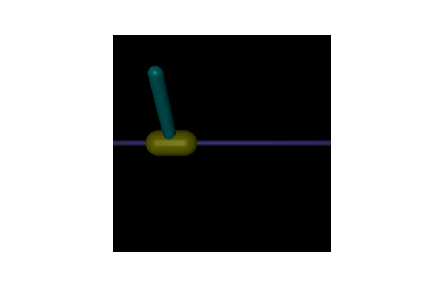
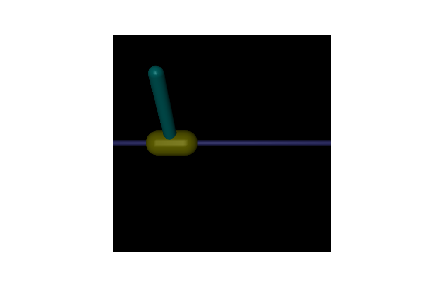
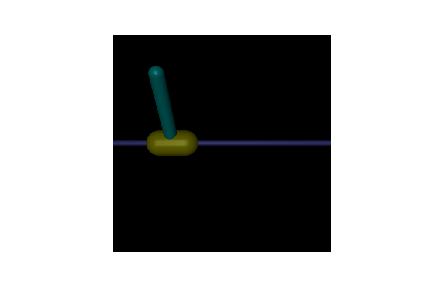
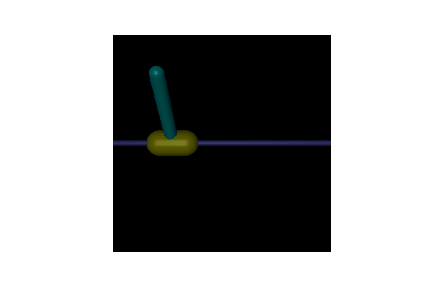
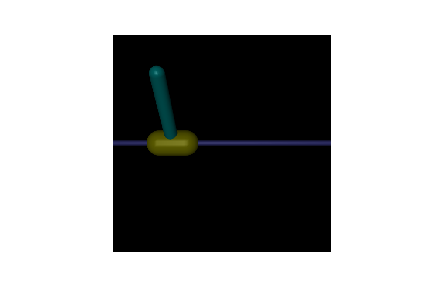
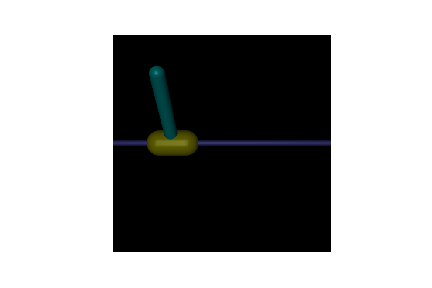
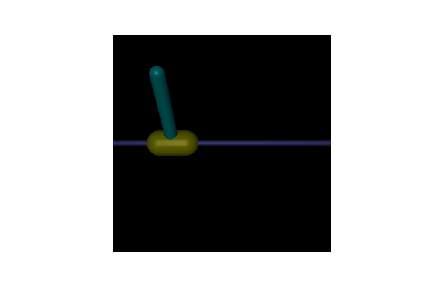
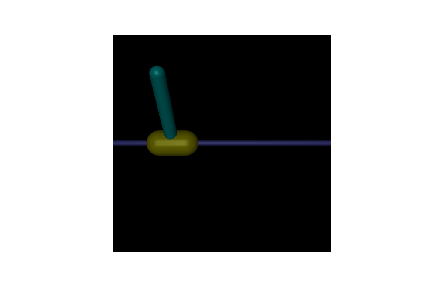
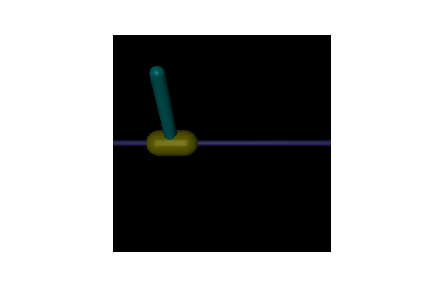
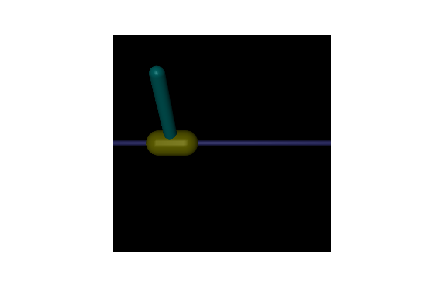
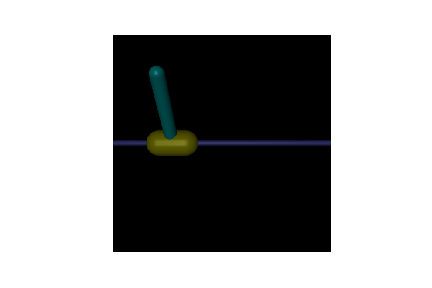
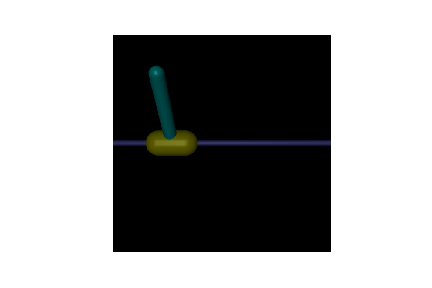
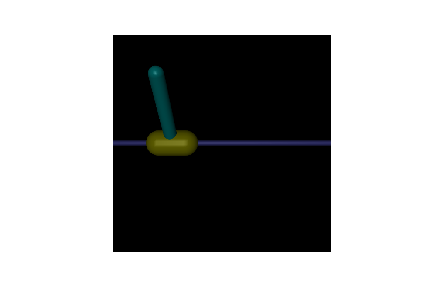
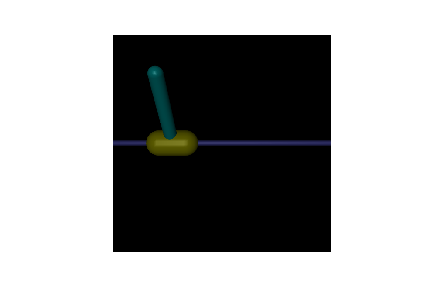
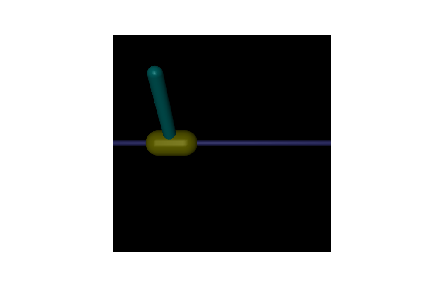
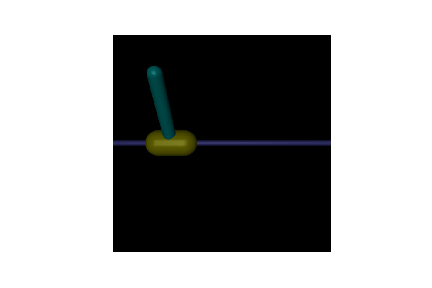
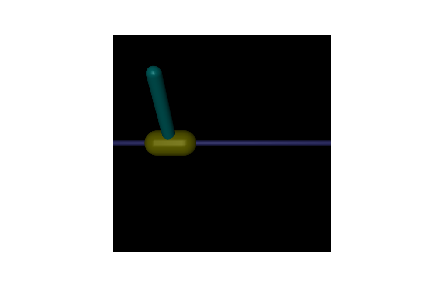
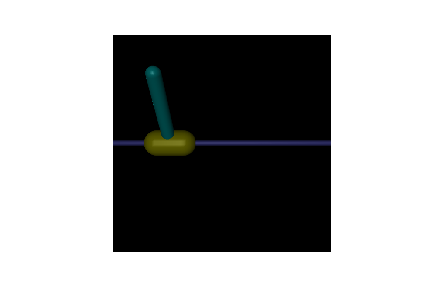
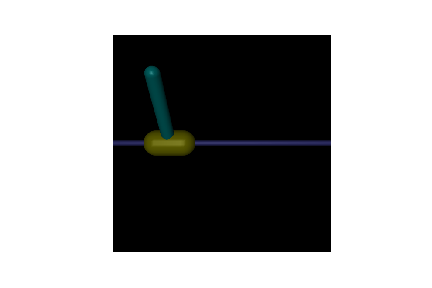
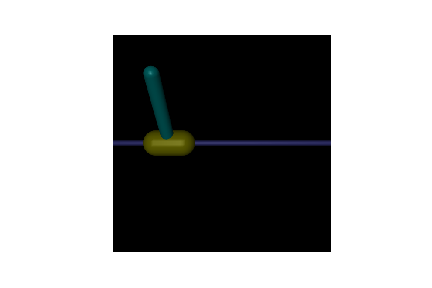
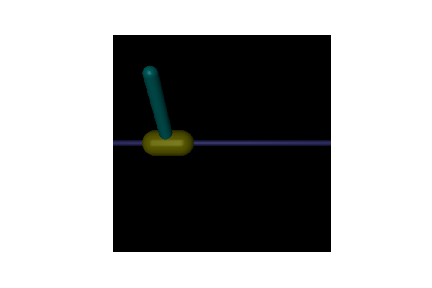
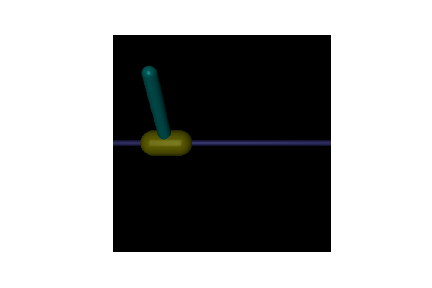
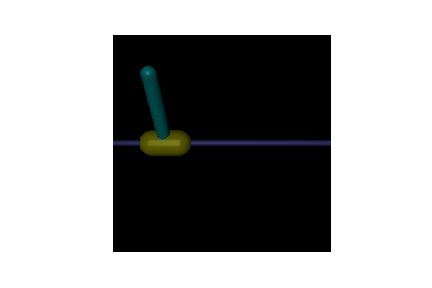
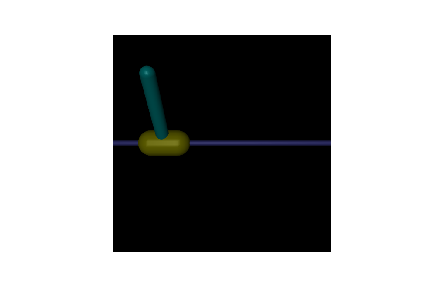
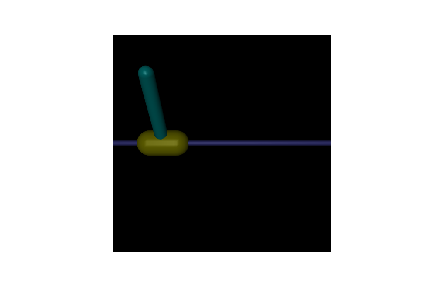
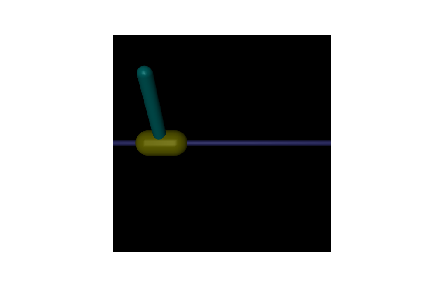
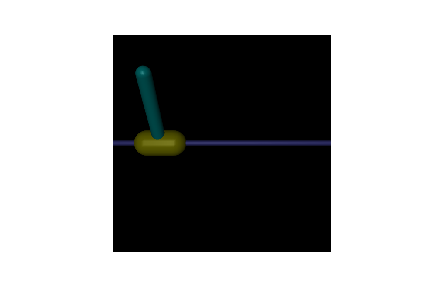
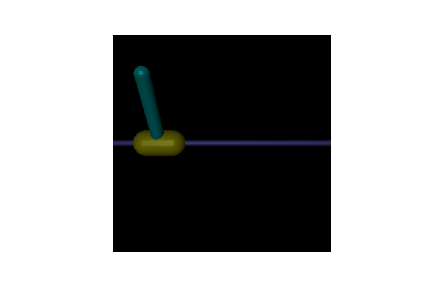
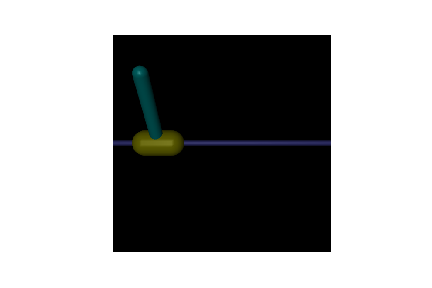
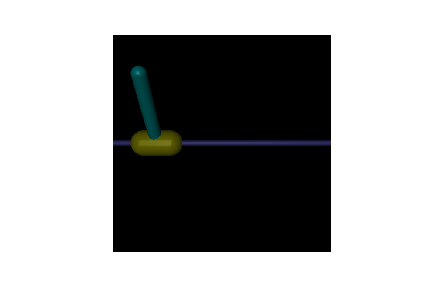
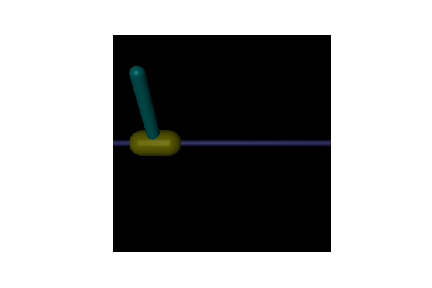
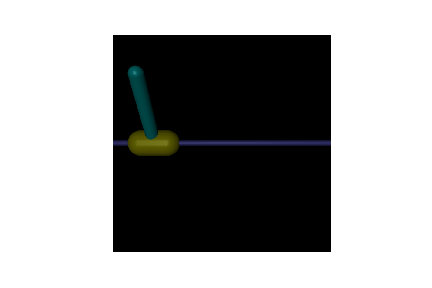
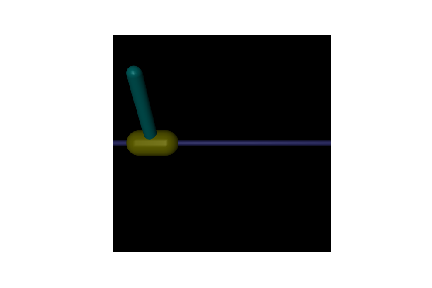
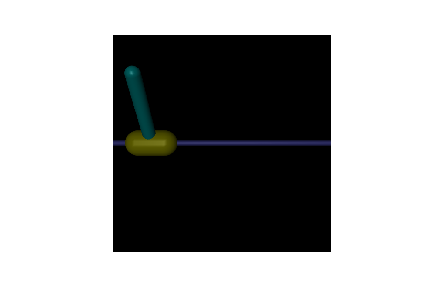
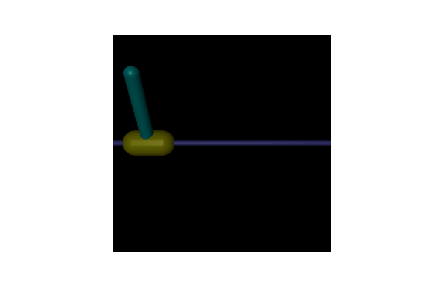
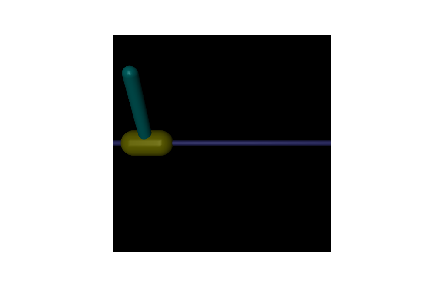
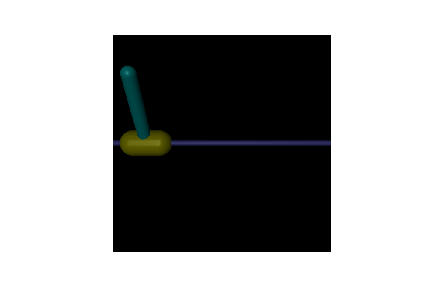
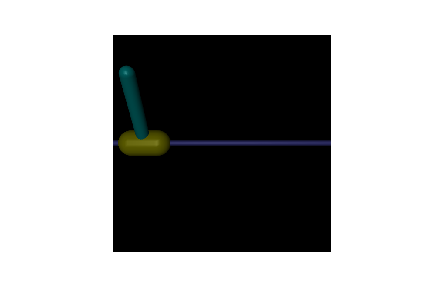
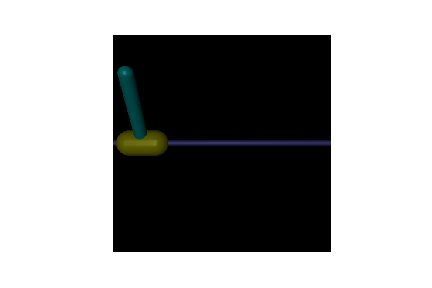
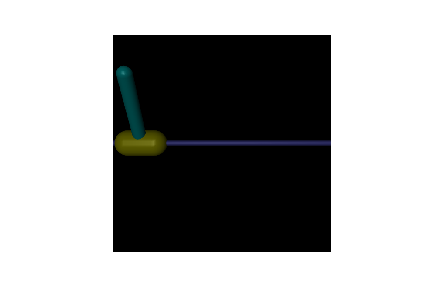
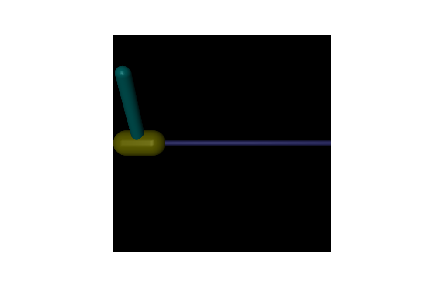
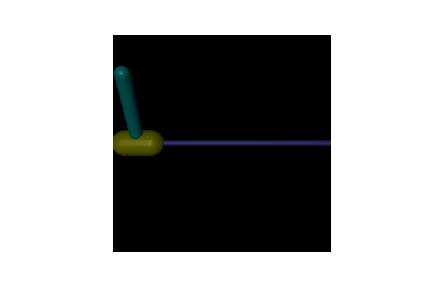
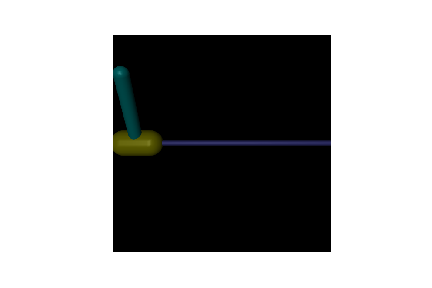
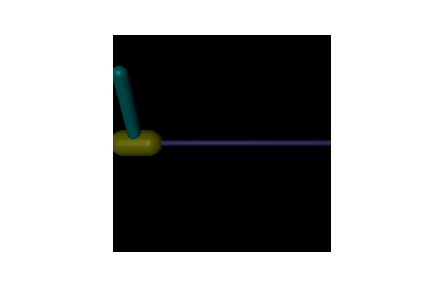
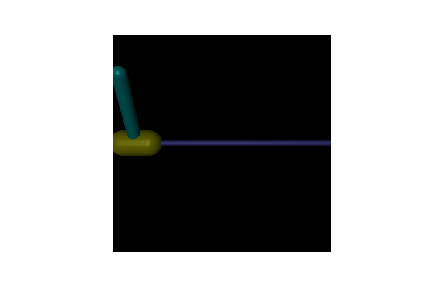
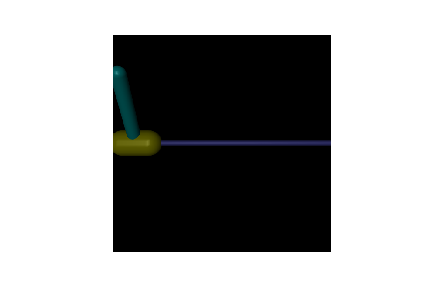
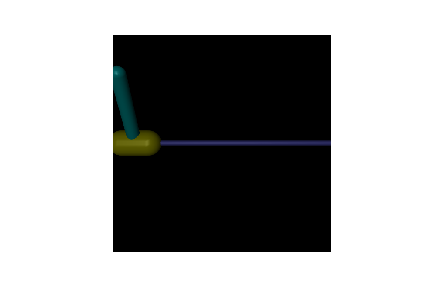
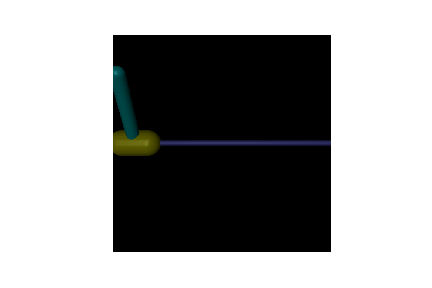
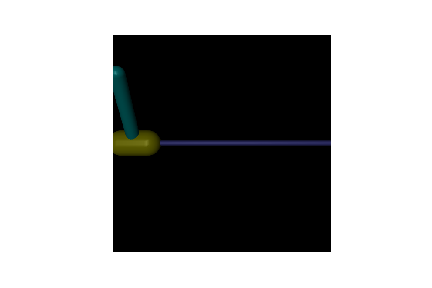
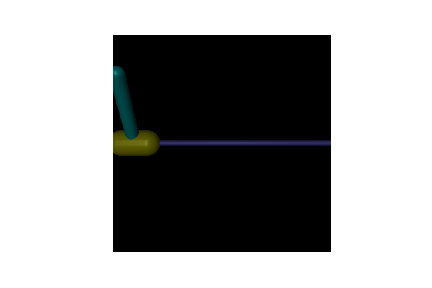
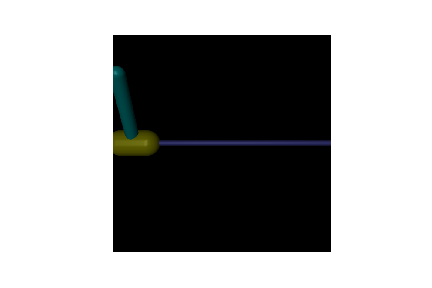
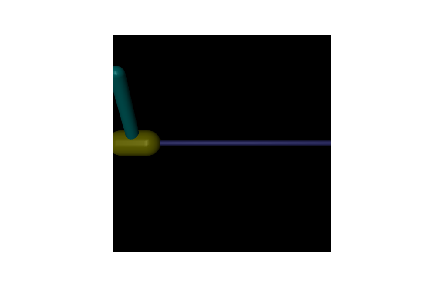
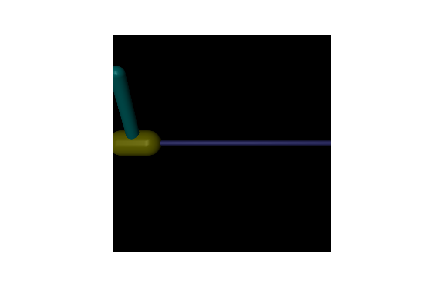
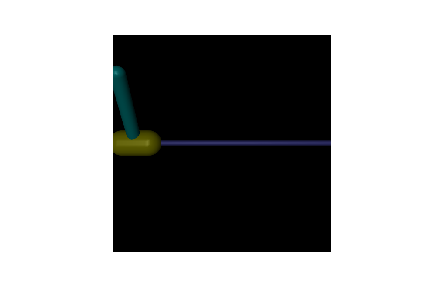
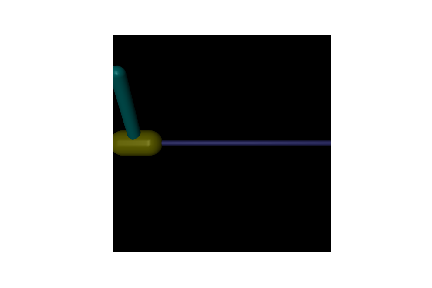
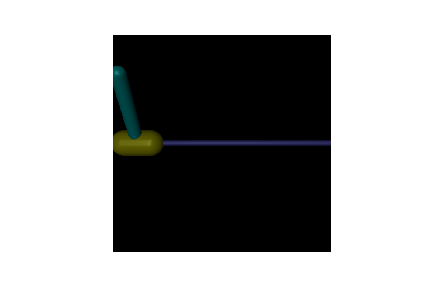
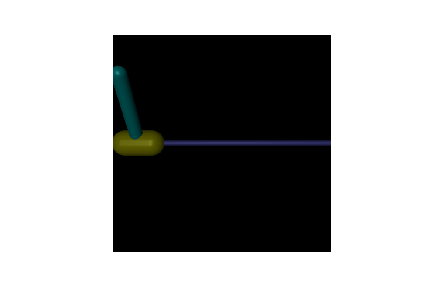
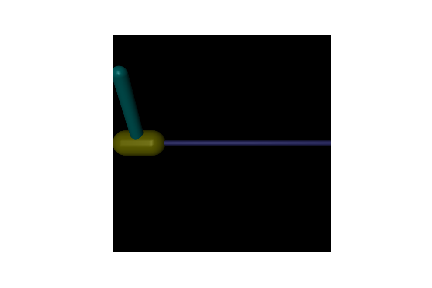
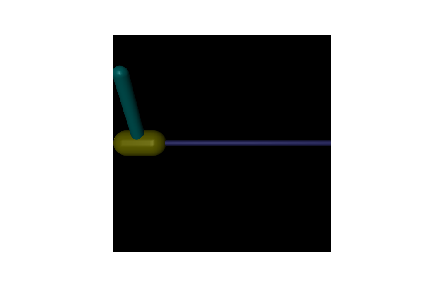
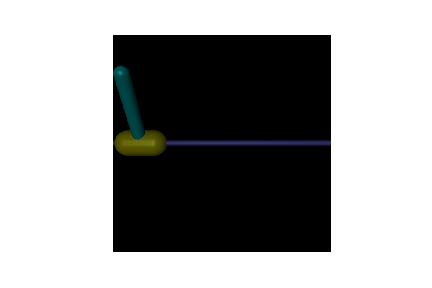
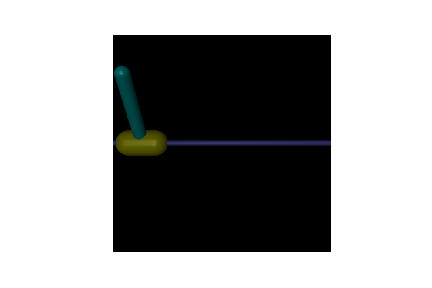
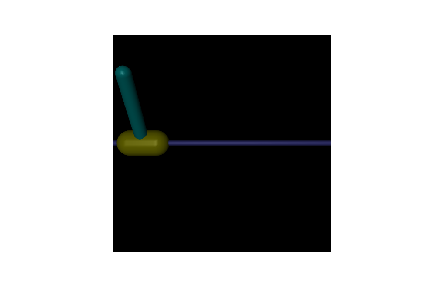
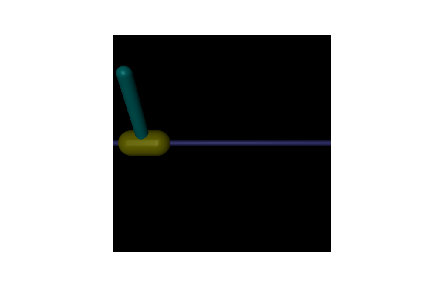
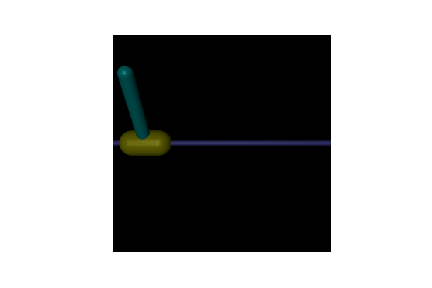
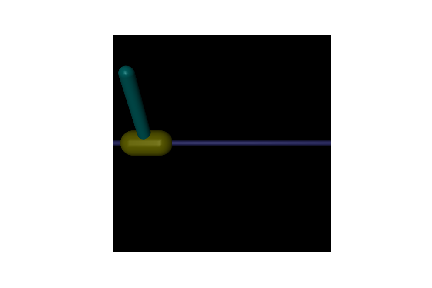
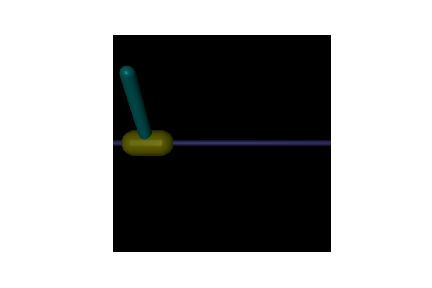
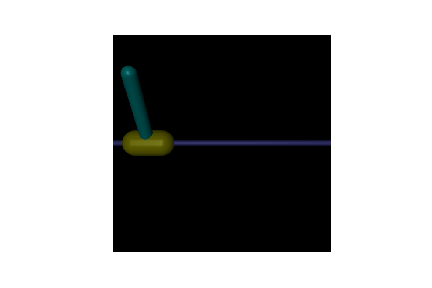
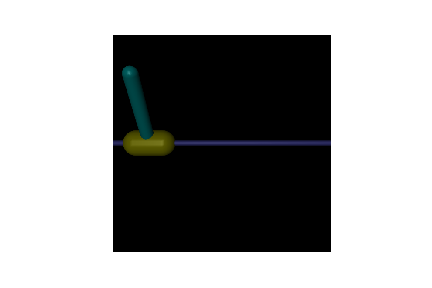
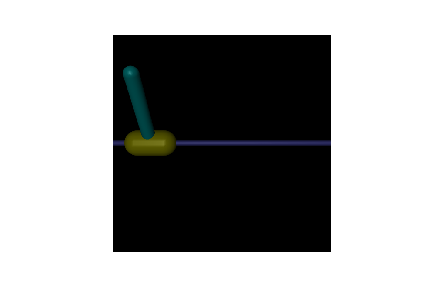
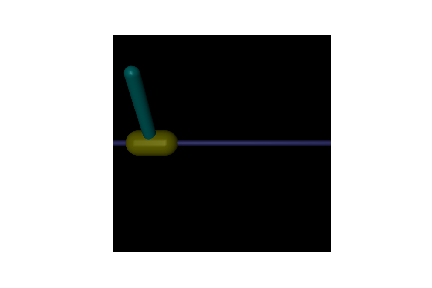
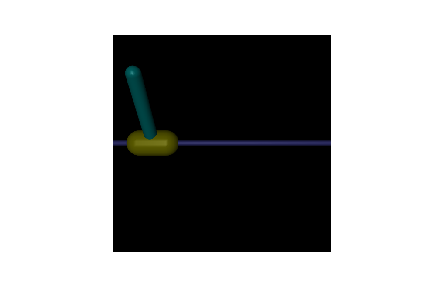
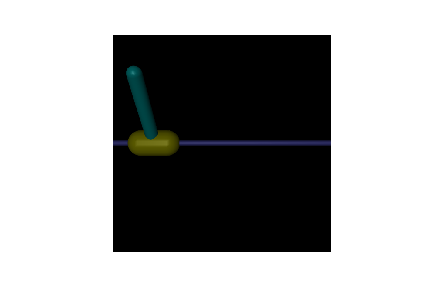
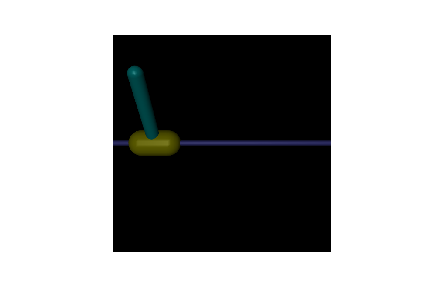
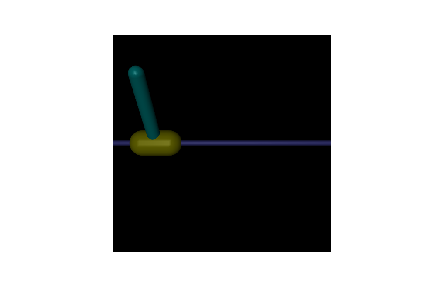
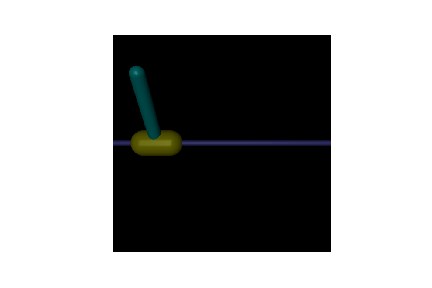
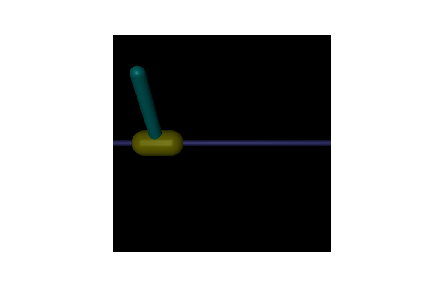
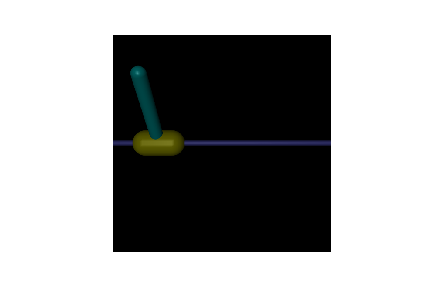
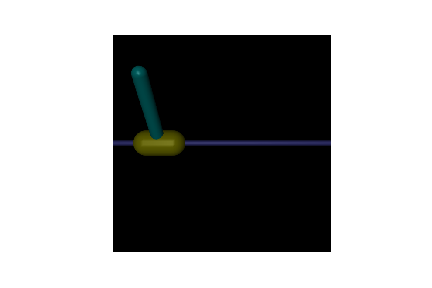
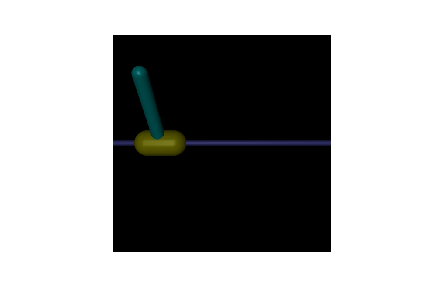
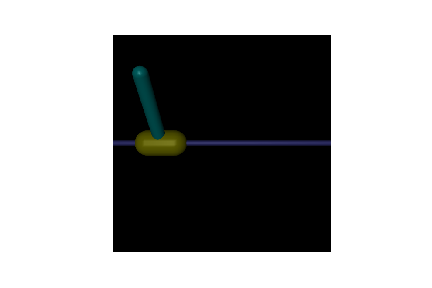
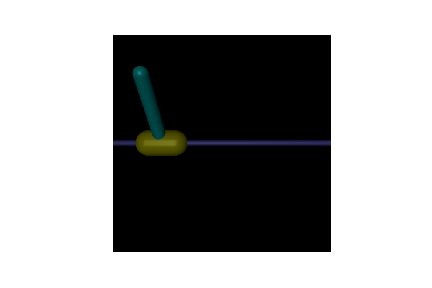
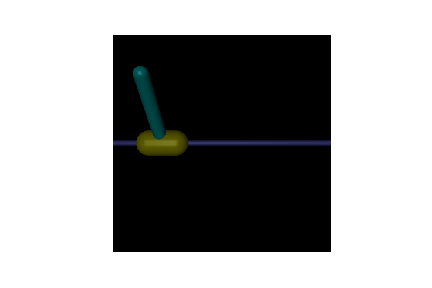
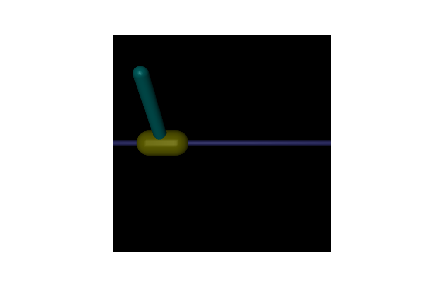
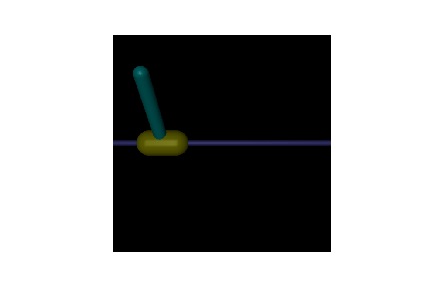
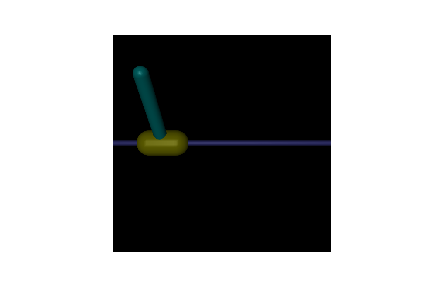
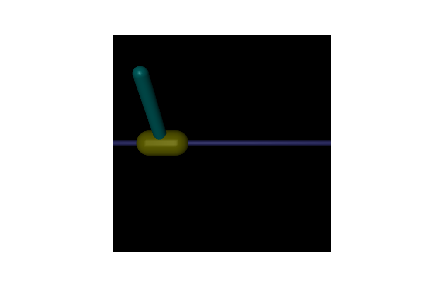
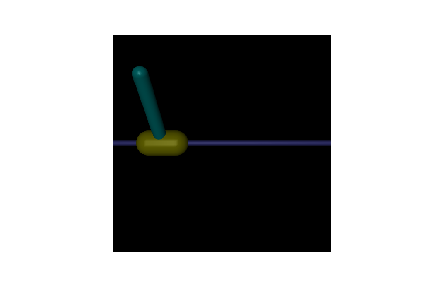
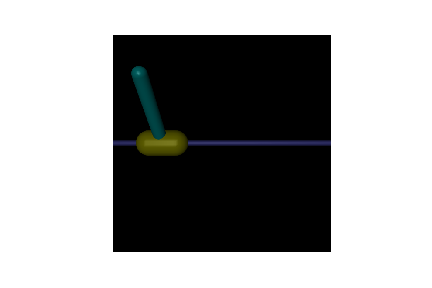
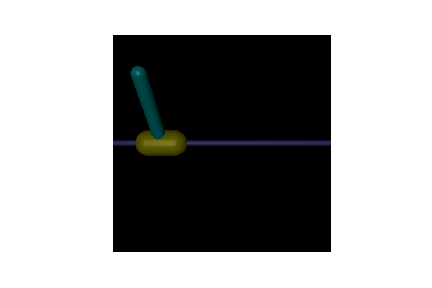
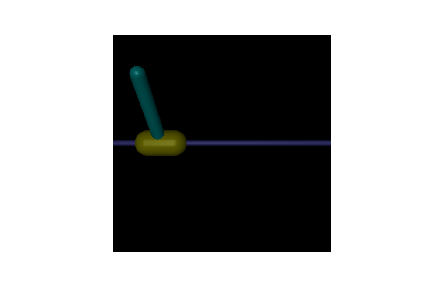
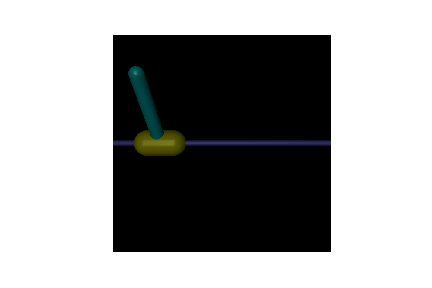
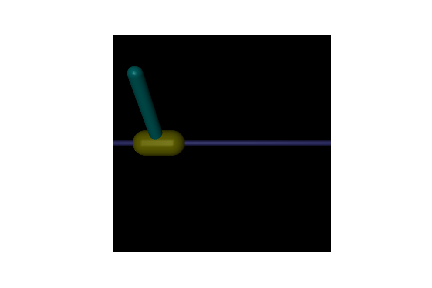
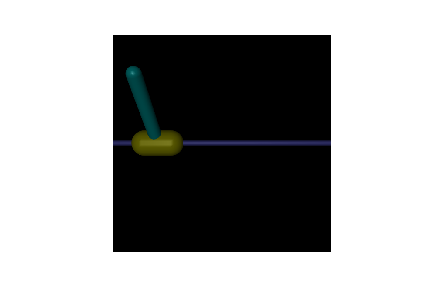
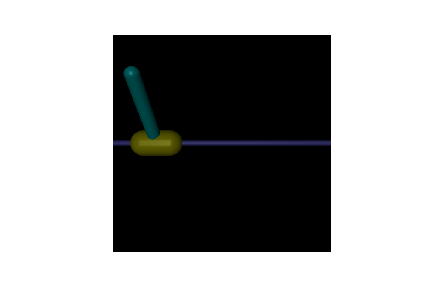
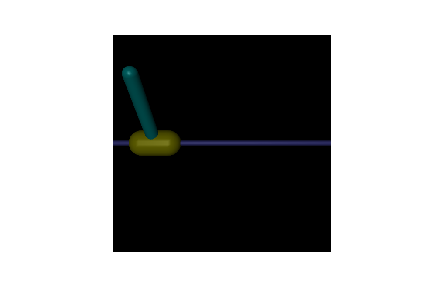
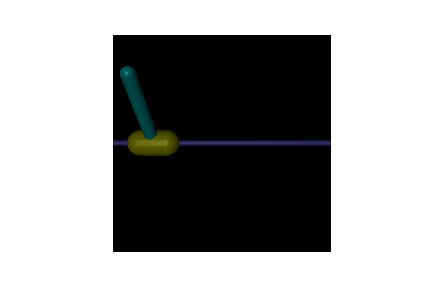
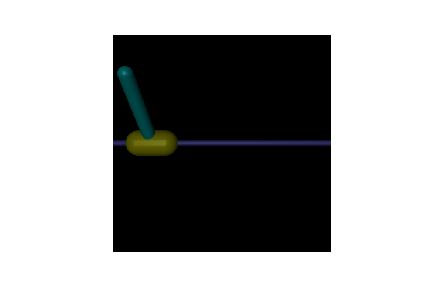
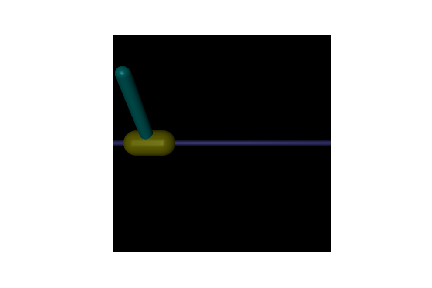
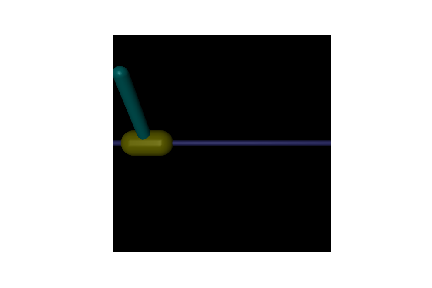
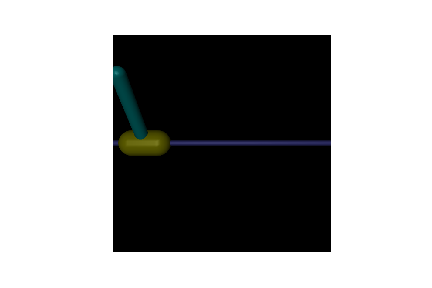
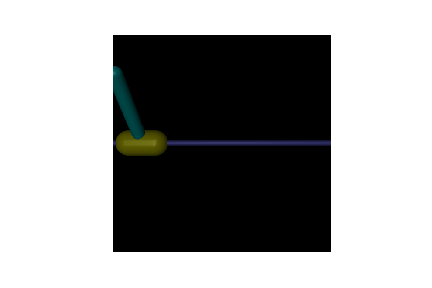
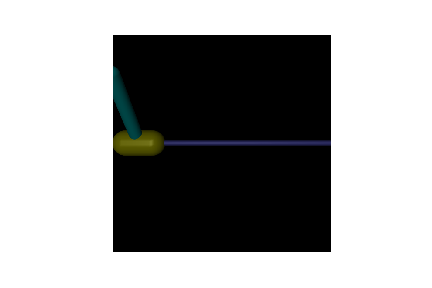
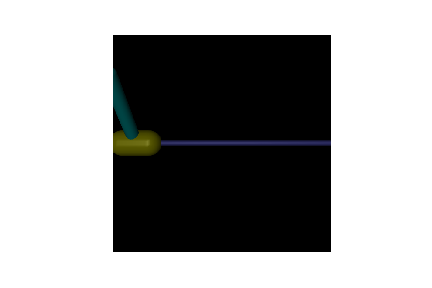
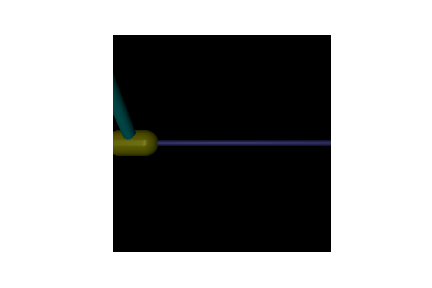
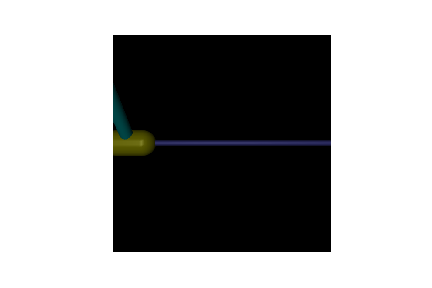
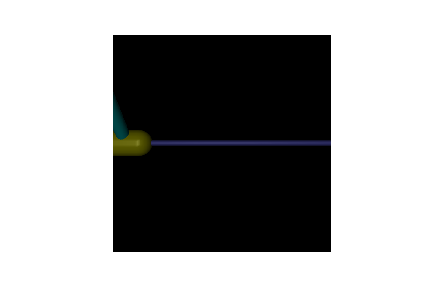
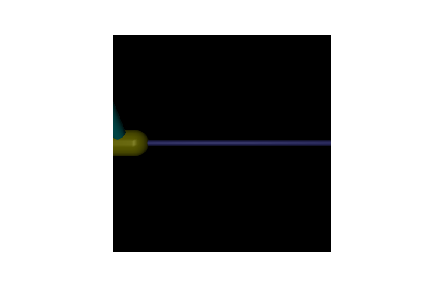
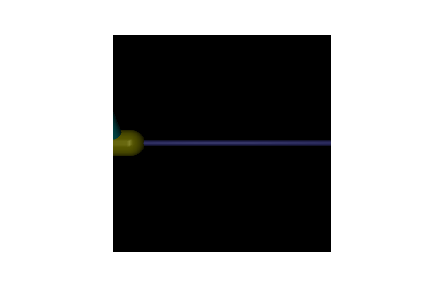
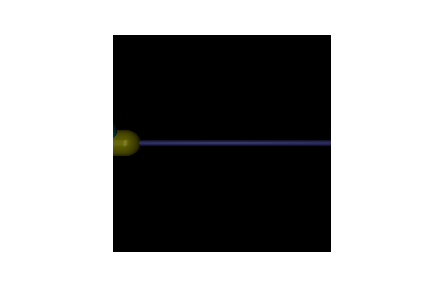
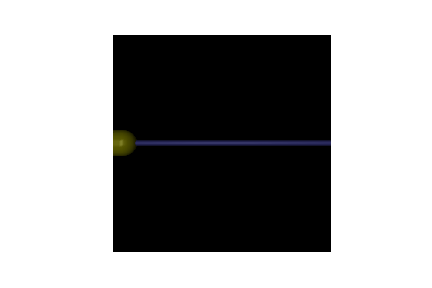
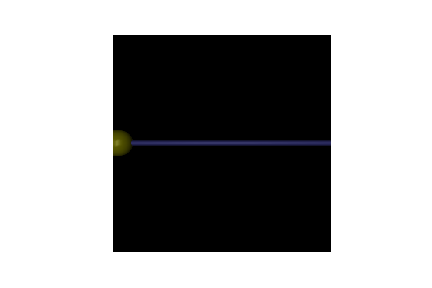
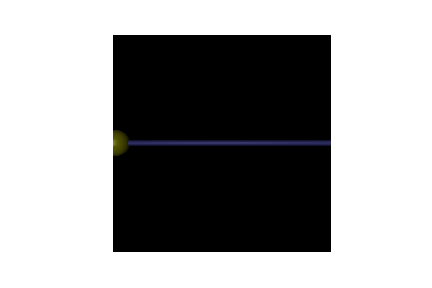
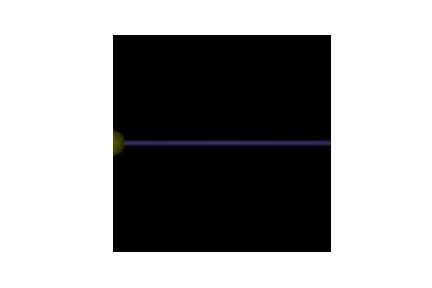
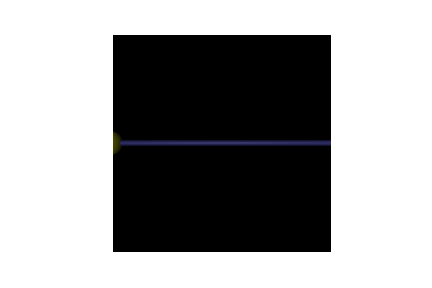
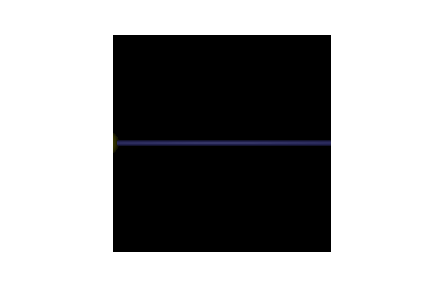
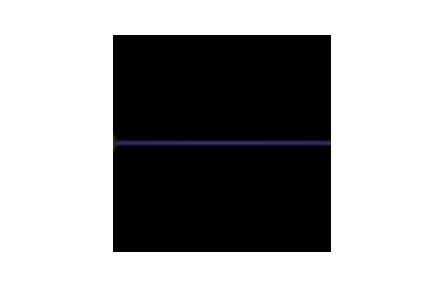
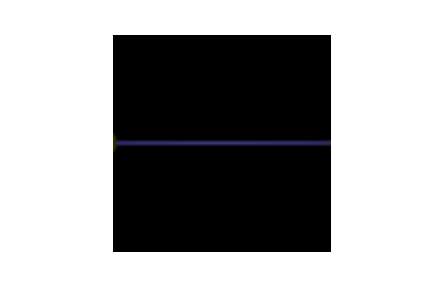
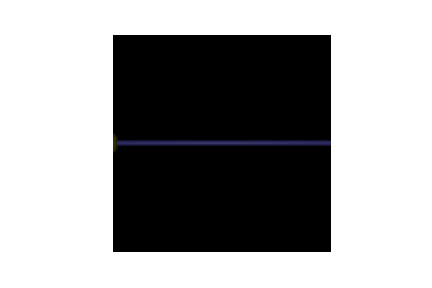

In [21]:
frames = []
total_reward = 0
state = env.reset()
for t in range(2000):
    action, _ = agent.policy.act(state)
    frames.append(env.render(mode='rgb_array')) 
    next_state, reward, done, _ = env.step(action)
    state=next_state
    total_reward+= reward
    if done:
        break

print ("Total reward:",total_reward)
env.close()
animate_frames(frames)